## Name: AAfaq Iqbal Khan

## Student ID: x20108851

In [3]:
#Importing all required libraries
import pandas as pd
import numpy as np
import math
import random
import statistics
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import simpy
import simpy.events as evt
import random
from random import random

In [4]:
# Utilities
def isZero(x, ε = 0.00001):
    return abs(x)<ε

### Random Generator

In [5]:
gen_x_tab = None
gen_y_tab = None

def pdfv(x, mean=0, sd=None, delta=None):
    
    if sd is None and delta is None:
        sd = 1
    elif sd is None and delta is not None:
        sd = delta/math.sqrt(6)*0.9275
    
    τ = math.sqrt(6)
    x = (x-mean)/sd*0.9275
    return np.where(abs(x)<τ, 5/(8*τ*sd)*(1-x**2/2+x**4/24+1/2)*0.9275, 0)

def rv(mean=0, sd=None, delta=None, alternating=None, rounding=None):
    
    if sd is None and delta is None:
        sd = 1
    elif sd is None and delta is not None:
        sd = delta/math.sqrt(6)*0.9275

    global gen_count, gen_x_tab, gen_y_tab
    
    if gen_x_tab is None:
        
        # initialise global variables 
        gen_x_tab = list(np.linspace(-math.sqrt(6), -1.51, 500)) + \
                    list(np.linspace(-1.5, 0, 151)) 

        τ = math.sqrt(6)
        
        def cdf(x):
            return 5/(8*τ)*(x**5/120-x**3/6+x*3/2)+5/(8*τ)*(τ**5/120-τ**3/6+τ*3/2)
        
        gen_y_tab = [ cdf(x) for x in gen_x_tab ]
        
    y, sign = random.random(), 1
    if y>0.5:
        y, sign = 1-y, -1
    if alternating is not None:
        sign = 1 if alternating%2==0 else -1

    for i in range(1, len(gen_x_tab)):
        if y < gen_y_tab[i]:
            x0 = gen_x_tab[i]
            y0 = gen_y_tab[i]
            x1 = gen_x_tab[i-1]
            y1 = gen_y_tab[i-1]
            x = mean+sign*((x0+(y-y0)*(x1-x0)/(y1-y0))*sd/0.9275)
            if type(rounding) is int and rounding>0:
                return round(x, rounding)
            else:
                return x

# Entities

In [6]:
def normaliseDirection(d):
    d = d.lower()
    if d=='r' or d=='fast':
        return 'fast'
    elif d=='l' or d=='slow':
        return 'slow'
    else:
        return None

### Lanes Entity

In [7]:
LANE_ID = 0

class Lane:
    
    def __init__(self, rec, length, speedLimit=None, merge=None):
        
        global LANE_ID
        self.id = LANE_ID
        LANE_ID += 1
      
        self.rec = rec
        self.x0 = 0
        self.length = length
        
        # speed limit on this lane segment in km/h
        self.speedLimit = speedLimit 
        
        # indicates that at the end of the lance traffic has to merge to the left or right
        self.merge = merge 
        
        self.vehicles = []
        
        self.next = None
        self.prev = None
                
        # lane attached to the left/right
        self.left = None
        self.right = None
        
        rec.recordLane(self)
      
    # defines generic str() method for Lanes
    def __str__(self):
        l = " L:--" if self.left is None else f" L:{self.left.id:0>2d}"
        r = " R:--" if self.right is None else f" R:{self.right.id:0>2d}"
        s = "" if self.speedLimit is None else f" speedLimit:{self.speedLimit:d}km/h"
        return f"[{self.id:0>2d} x={self.x0:3.1f}m l={self.length:3.1f}m"+l+r+s+"]" + \
                    ("\\" if self.merge=='R' else "") + \
                    ("/" if self.merge=='L' else "") + \
                    ("-" + str(self.next) if self.next is not None else "")
    
    def getLane(self, direction):
        if direction=='slow':
            return self.left
        elif direction=='fast':
            return self.right
        else:
            return None

    ## additional code    
    # adding parallel lane on right side
    def attachRight(self, lane):
        self.right = lane
        lane.left = self
        lane.x0 = self.x0
        lane.speedLimit = self.speedLimit
 
    ## additional code 
    # adding parallel lane on right side
    def attachLeft(self, lane):
        self.left = lane
        lane.right = self
        lane.x0 = self.x0
        lane.speedLimit = self.speedLimit
     
    ## additional code 
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenRight(self):
        lane = self
        newLane = Lane(self.rec, lane.length)
        lane.attachRight(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(self.rec, lane.length)
            lane.attachRight(newLane)
            newLane.prev = lane.prev.right
            newLane.prev.next = newLane
        return self.right
            
    ## additional code 
    # constructs a number of lane segments of the same length
    # and attaches them to the right
    def widenLeft(self):
        lane = self
        newLane = Lane(self.rec, lane.length)
        lane.attachLeft(newLane)
        while lane.next is not None:
            lane = lane.next
            newLane = Lane(self.rec, lane.length)
            lane.attachLeft(newLane)
            newLane.prev = lane.prev.left
            newLane.prev.next = newLane
        return self.left
            
    # defines concatenation of lanes
    def extend(self, lane):
        l = self
        while l.next is not None:
            l = l.next
        l.next = lane
        lane.x0 = l.x0+l.length
        lane.prev = l
        return self
        
    def totalLength(self):
        total = self.length
        l = self
        while l.next is not None:
            l = l.next
            total += l.length
        return total
    
    def between(self, posBack, posFront):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
                # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        res = []
        for v in self.vehicles:
            if posBack < v.pos and v.pos-v.length < posFront:
                res.append(v)
        # if the required distance reaches over the end of the lane segment
        if posFront > self.length and self.next is not None:
            return res + self.next.between(0, posFront-self.length)
        elif posBack < 0 and self.prev is not None:
            return self.prev.between(self.prev.length+posBack, self.prev.length) + res
        else:
            return res
        
    def inFront(self, pos, far):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # normally the list should be sorted, but just in case
        self.vehicles.sort(key=lambda v: v.pos)
        for v in self.vehicles:
            if v.pos > pos:
                return v if v.pos-pos<far else None
        # there is none in front in this lance
        # if the free lane in front is long enough or there is no next lane
        if self.length-pos>far or self.next is None:
            return None
        else:
            return self.next.inFront(0, far-(self.length-pos))

    def behind(self, pos, far):
        # make sure that the position of all cars is accurate 
        # at this point in time
        for v in self.vehicles:
            v.updateOnly()
        # This time we sort in reverse order
        self.vehicles.sort(key=lambda v: v.pos, reverse=True)
        for v in self.vehicles:
            if v.pos < pos:
                return v if pos-v.pos<far else None
        # there is none behind in this lance
        # if the free lane in behind is long enough or there is no previous lane
        if pos>far or self.prev is None:
            return None
        else:
            return self.prev.behind(self.prev.length, far-pos)
        
    def enter(self, vehicle, pos=0, laneChange=False):
        self.vehicles.insert(0, vehicle)
        vehicle.pos = pos
        vehicle.lane = self
        vehicle.rec.record(vehicle, event="enter lane"+(f" {self.id:d}" if laneChange else ""))

    def leave(self, vehicle, laneChange=False):
        vehicle.rec.record(vehicle, event="leave lane"+(f" {self.id:d}" if laneChange else ""))
        vehicle.lane = None
        self.vehicles.remove(vehicle)

### Vehicle Entity

In [8]:
def isRunning(p):
    return p is not None and p.running

def isCrashed(p):
    return p is not None and p.crashed

In [9]:
VEHICLE_ID = 0
#vehicle_dict=dict of carname: (max_speed,max_acceleration,length and ideally width)


#VEHICLE_DICT={"Nissan Saloon":(240,4.67,5.12),"Renault Clio Hatchback":(161,1.6,4.05),"Ford Fiesta Hatchback":(200,2.9,4.068),"Electric car":(160,2.3,3.89),"HGV":(140,1.8,15)}

class Vehicle:
    def __init__(self, rec, 
                 startingLane=None, startingPos=0,
                 t0=0, x0=0, dx0=0, ddx0=0, dddx0=0, 
                 vmax=None, vmax_var=None,a_max=None,
                 t=[], v=[],VEHICLE_MODEL="car"):
        
        global VEHICLE_ID
        self.id = VEHICLE_ID
        VEHICLE_ID += 1
        #self.vehicle=list(VEHICLE_DICT.keys())[VEHICLE_ID-1]
        
        self.VEHICLE_MODEL=VEHICLE_MODEL

        if self.VEHICLE_MODEL=="car":
            self.a_max=2.5
            self.a_brake = -4.0 # [m/s²]   
            self.a_coast = -0.6 # [m/s²]
            self.length = 4 
                        
        elif self.VEHICLE_MODEL=="HGV":
            self.a_max=1.8
            self.a_brake = -2.5 # [m/s²]   
            self.a_coast = -1.3 # [m/s²]
            self.length = 15
            
        elif self.VEHICLE_MODEL=="electric car":
        
            self.a_max= 4.6
            self.a_brake = -8.0 # [m/s²]   
            self.a_coast = -1.8 # [m/s²]
            self.length = 4.6
                
        else:
            self.a_brake = -4.0 # [m/s²] 
            self.a_coast = -0.6 # [m/s²] 
            self.a_max= 2.5 
            self.length = 4.6
            
        
        
        self.a_max =    a_max # [m/s²]   Tesla:  4.6 # [m/s²] 
                            # Note: 2.5m/s² corresponds to 0-100km/h om 11s
      #  self.length = 4 # [m]  Length of the vehicle 
        self.VEHICLE_LENGTH=4
        
        self.absolute_speed_time_tolerance = 2 # [s]
        self.relative_speed_time_tolerance = 5 # [s]
        self.far_away_in_front = 200 # [m]
        self.far_away_in_back = 80 # [m]
        self.min_action_time = 0.5 # [s]  
        
        self.lane_change_time = 3 # [s] 
        self.min_speed_diff = 2 # [m/s]
        
        ## if not None the preferred max free velocity
        self.vmax = vmax
        self.vmax_variation = vmax_var if vmax_var is not None else 0.05
        self.timing = 100 # [s]
        self.timing_variation = 0.30 
        
        self.env = rec.env
        self.rec = rec
            
        self.startingLane = startingLane
        self.startingPos = startingPos
        self.lane = None
        self.pos = 0
        
        # speedLimit once recognised
        self.speedLimit = None
        
        ## second lane reference during changing of lanes
        self.oldLane = None
        
        self.alternator = 0
            
        self.t0 = t0
        self.x0 = x0    # [m] the reference point is on the front of the vehicle
                        # the body of the vehicle of the given length is behind.
        self.dx0 = dx0
        self.ddx0 = ddx0
        self.dddx0 = dddx0

        self.t_target = t
        self.v_target = v
        # while there is an adjustment of velocity in progress
        # the current_target is set
        self.current_target = None

        # trace flags
        self.traceAdjustVelocity = False
        self.traceInterrupt = False
        self.traceBraking = False
        self.traceCrash = False
        self.traceSurround = False
        self.traceOvertaking = False
 
        # start process
        self.running = False
        self.crashed = False
                
        # Flags used for temporarily exclusive behaviour
        self.laneChangeControl = False 
                # This flag is used to block automatic overtaking
                # while processing explicit lane change control
        self.braking = False
                # This flag is used to prevent interrupting braking for braking
        self.changingLane = False
                # This flag is used to prevent interrupting lanechanging
        
        self.processRef = None
        self.env.process(self.process())
    
    def trace(self, message):
        print(f"t={self.t0:7,.1f}s x={self.x0:7,.1f}m v{self.id:d}", message)
        
    def isNotFasterThan(self, other):
        return True if other is None else self.dx0 <= other.dx0
    
    def isNotSlowerThan(self, other):
        return True if other is None else other.dx0 <= self.dx0
    
    ## adapted to handle lane information
    def updateOnly(self):
        t = self.env.now
        if t < self.t0 or not self.running:
            return False
        if t > self.t0:
            dt = t - self.t0
            ddx = self.ddx0 + self.dddx0*dt
            dx = self.dx0 + self.ddx0*dt + self.dddx0*dt*dt/2
            Δx = self.dx0*dt + self.ddx0*dt*dt/2 + self.dddx0*dt*dt*dt/6
            x = round(self.x0 + Δx, 2)
            self.t0, self.x0, self.dx0, self.ddx0 = t, x, dx, ddx
            
            ## begin additional code
            self.pos = round(self.pos+Δx, 2)
            # update lane information if necessary
            if self.pos >= self.lane.length:
                nextPos = self.pos - self.lane.length
                nextLane = self.lane.next
                self.lane.leave(self)
                if nextLane is None:
                    self.oldLane = None
                    self.rec.record(self, event='end')
                    self.running = False
                    return False
                else:
                    nextLane.enter(self, pos=nextPos)
            ## end additional code
            
        return True
        
    ## minor change only
    def update(self):
        
        self.surround = Surround(self)
        
        ## instead of direct link, call method
        inFront = self.surround.front
        
        # if there is a running or crashed vehicle in front and
        # we have crashed into the rear end of that vehicle
        if inFront is not None and inFront.x0-inFront.length < self.x0+self.VEHICLE_LENGTH:
            self.crash(inFront)

        # if the speedLimit changes...
        elif self.speedLimit != self.lane.speedLimit:
            self.speedLimit = self.lane.speedLimit
            if self.speedLimit is None:
                # end of speed limit, return to default behaviour
                if self.vmax is not None and self.vmax>self.dx0:
                    Δt = max(self.min_action_time, (self.vmax-self.dx0)/self.a_max)
                    self.setTarget(Δt, self.vmax)
            else:
                vmax = self.speedLimit/3.6
                vmax = rv(mean=vmax, delta=self.vmax_variation*vmax)
                if vmax<self.dx0:
                    # when the new speedLimit is lower than current speed, coast down
                    Δt = max(self.min_action_time, (self.dx0-vmax)/self.a_coast)
                    self.setTarget(Δt, vmax)
                else:
                    # when the new speedLimit is higher than current speed, accelerate at half max a_max
                    Δt = max(self.min_action_time, 2*(vmax-self.dx0)/self.a_max)
                    self.setTarget(Δt, vmax)
                
        # if at the end of the lane merging is required      
        elif self.lane.merge is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane:
            if self.lane.merge == 'R':
                if self.surround.rightLane is not None and \
                        self.surround.right is None and \
                        self.isNotFasterThan(self.surround.rightFront) and \
                        self.isNotSlowerThan(self.surround.rightBack):
                    self.setTarget(self.lane_change_time, 'fast')
            elif self.lane.merge == 'L':
                if self.surround.leftLane is not None and \
                        self.surround.left is None and \
                        self.isNotFasterThan(self.surround.leftFront) and \
                        self.isNotSlowerThan(self.surround.leftBack):
                    self.setTarget(self.lane_change_time, 'slow')                
        
        # start overtaking maneuver by changing into fast lane
        elif inFront is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.dx0 > inFront.dx0 + self.min_speed_diff and \
                self.x0 + (self.lane_change_time+self.absolute_speed_time_tolerance)*self.dx0 > inFront.x0-inFront.length and \
                self.surround.rightLane is not None and \
                self.surround.right is None and \
                self.isNotFasterThan(self.surround.rightFront) and \
                self.isNotSlowerThan(self.surround.rightBack):
            self.setTarget(self.lane_change_time, 'fast')

        # if there is a vehicle in front 
        # which drives slower and
        # the distance to that vehicle in front is at current speed
        # less than the critical time tolerance of this driver
        elif inFront is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.dx0 > inFront.dx0 and \
                self.x0 + self.absolute_speed_time_tolerance*self.dx0 > inFront.x0:
            # note that self.a_coast is a negative acceleration
            Δt = max(self.min_action_time, (inFront.dx0-self.dx0)/self.a_coast)
            if self.current_target is None or \
                    not isZero(self.current_target-inFront.dx0):
                self.setTarget(Δt, inFront.dx0)

        # end overtaking by returning to slow lane
        elif self.surround.leftLane is not None and \
                not self.braking and not self.laneChangeControl and not self.changingLane and \
                self.surround.leftLane.totalLength()-self.pos>100 and \
                self.surround.left is None and \
                self.isNotSlowerThan(self.surround.leftBack) and \
                self.surround.leftFront is None:
            self.setTarget(self.lane_change_time, 'slow')
     
    ## code remains unchanged
    def setTarget(self, t, v):
        self.t_target = [ t ] + self.t_target
        self.v_target = [ v ] + self.v_target
        self.interruptProcess()
      
    ## minor change only
    def process(self):

        # delay start to the given time t-
        if self.t0>self.env.now:
            yield self.env.timeout(self.t0-self.env.now)
        self.t0 = self.env.now
        self.running = True
        self.rec.startRecording(self)
        
        ## begin additional code
        ## enter the first lane
        self.startingLane.enter(self)
        ## end additional code
        
        while self.updateOnly():

            ## instead of direct link, call method
            inFront = self.lane.inFront(self.pos, self.far_away_in_front) \
                        if self.lane is not None else None
                
            # if the car in front is slower and we are a bit too near on its heals...
            if inFront is not None and inFront.dx0 < self.dx0 and \
                    inFront.x0-inFront.length < \
                        self.x0 + self.relative_speed_time_tolerance*(self.dx0-inFront.dx0):
                yield from self.emergencyBraking(inFront.dx0)
                if not isZero(self.dx0-inFront.dx0):
                    # after emergency breaking adjust to the speed of the car in front...
                    Δt = 1
                    self.setTarget(Δt, inFront.dx0)
                continue 
                    
            if len(self.t_target)>0:
                
                t_target = self.t_target[0]
                v_target = self.v_target[0]
                self.t_target = self.t_target[1:]
                self.v_target = self.v_target[1:]
                
                if type(v_target) is str:
                    
                    # explicit overtake commands temporarily
                    # disable overtaking
                    if v_target=='R':
                        self.laneChangeControl = True
                    elif v_target=='L':
                        self.laneChangeControl = False
                        
                    direction = normaliseDirection(v_target)
                    if self.lane.getLane(direction) is not None:
                        yield from self.changeLane(inFront, direction, t_target)
                
                ## the rest is what was there before
                else:
                    v0 = self.dx0
                    v1 = v_target
                    Δt = t_target
                    if isZero(v1-v0):
                        yield from self.continueAtSameSpeed(Δt)
                    else:
                        yield from self.adjustVelocity(v1-v0, Δt)
                    
            ## additional code
            elif self.vmax is not None:
                
                # if the explicit control strategy is exhausted and
                # a target maximum speed is set the vehicle will follow
                # a random speed around the target maximum speed

                ## additional code
                vmax = self.vmax
                if self.speedLimit is not None:
                    vmax = self.speedLimit/3.6
                    vmax = rv(mean=vmax, delta=self.vmax_variation*vmax)
                    
                # as long there is no vehicle in front or the vehicle in front
                # is far enough ahead
                if inFront is None or \
                    self.x0 + self.relative_speed_time_tolerance*(self.dx0-inFront.dx0) < inFront.x0:
                    v0 = self.dx0
                    self.alternator += 1
                    v1 = rv(mean=vmax, 
                            delta=self.vmax_variation*vmax, 
                            alternating=self.alternator,
                            rounding=2)
                    Δt = rv(mean=self.timing, 
                            delta=self.timing*self.timing_variation,
                            rounding=1)
                
                    yield from self.adjustVelocity(v1-v0, Δt)
                else:
                    yield from self.continueAtSameSpeed(10)
            else:
                yield from self.continueAtSameSpeed(10)
                
        self.rec.stopRecording(self)

    def crash(self, other):
        
        def recordCrash(v):
            v.rec.record(v, 'crash')
            v.running = False
            v.crashed = True
            # stop anything your are currently doing...
            v.interruptProcess()
            v.dx0 = 0
            v.ddx0 = 0
            v.dddx0 = 0
            
        if self.running:
            if self.traceCrash:
                self.trace(f"Crashed into v{other.id:d} at x={self.x0:7.1f}m")
            recordCrash(self)
            if other.running:
                recordCrash(other)
        
    def emergencyBraking(self, v):
        
        def emergencyBrakingProcess(v):
            
            if self.traceBraking:
                self.trace(f"Braking from v={self.dx0:4.1f}m/s to {v:4.1f}m/s")
           
            self.rec.record(self, 'brake')
            minΔt = 0.2
            self.dddx0 = (self.a_brake-self.ddx0)/minΔt      
            yield self.env.timeout(minΔt)
            
            self.updateOnly()
            self.dddx0=0
            self.ddx0=self.a_brake
            v = min(v, self.dx0-2)
                # the brake time estimate is for perfect timing for 
                # autonomous cars. For manual driving leave out the
                # -minΔt/2 or use a random element.
            Δt = max(0.5, (v-self.dx0)/self.ddx0 - minΔt/2)
            yield self.env.timeout(Δt)
                
            self.updateOnly()
            self.dddx0 = -self.ddx0/minΔt      
            yield self.env.timeout(minΔt)
      
            self.updateOnly()
            self.ddx0 = 0
            self.dddx0 = 0
            self.rec.record(self, 'brake end')
            
            if self.traceBraking:
                self.trace(f"Braking end  v={self.dx0:4.1f}m/s")

        ## The 'braking' bit prevents the interruption of an emergency breaking process 
        self.braking = True
        self.processRef = self.env.process(emergencyBrakingProcess(v))
        try:
            yield self.processRef
        except simpy.Interrupt:
            if self.traceInterrupt or self.traceBraking:
                self.trace(f"Braking interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.processRef = None
        self.braking = False
        
    def changeLane(self, inFront, direction, Δt):
     
        def changeLaneProcess(oldLane, newlane, Δt, trace=True):
            # self.updateOnly()
            if trace and self.traceOvertaking and inFront is not None and  direction=='fast':
                other = f"v{inFront.id:d} " if inFront is not None else ""
                self.trace(f"Overtaking {other:s} at x={self.x0:7,.1f}m")
                
            self.rec.record(self, 'change '+direction)
            self.oldLane = oldLane
            newLane.enter(self, pos=self.pos, laneChange=True) 
            self.ddx0 = 1
            self.dddx0 = 0
            yield self.env.timeout(Δt)
            
            self.updateOnly()
            if not self.running:
                return
            currentLane = self.lane
            self.oldLane.leave(self, laneChange=True)
            self.lane = currentLane
            self.oldLane = None
            self.ddx0 = 0
            self.dddx0 = 0
            self.rec.record(self, 'done change '+direction)
            
            if trace and self.traceOvertaking and direction=='slow':
                self.trace(f"Overtaking done return to slow lane at x={self.x0:7,.1f}m")
            # self.updateOnly()
        
        ## keep record of current lane, as in case of aborting
        ## the lane change 
        ## when interrupted go back into original lane
        self.changingLane = True
        self.updateOnly()
        oldLane = self.lane
        newLane = self.lane.getLane(direction)
        try:
            self.processRef = self.env.process(changeLaneProcess(oldLane, newLane, Δt))
            yield self.processRef
            self.processRef = None
        except simpy.Interrupt:
            if self.traceInterrupt and self.traceOvertaking:
                self.trace(f"Overtaking interrupted at x={self.x0:7,.1f}m")
            # if interrupted go quickly back into old lane
            # but this is not interruptible
            self.updateOnly()
            # it is possible that there was an intermittent change lane event
            while self.lane != newLane and newLane is not None:
                newLane = newLane.next
                oldLane = oldLane.next
            self.processRef = None
            self.env.process(changeLaneProcess(newLane, oldLane, Δt/4, trace=False))
        self.changingLane = False    
        
    # smoothly adjust velocity by Δv over the time Δt
    def adjustVelocity(self, Δv, Δt):
        
        # smoothly adjust velocity by Δv over the time Δt
        def adjustVelocityProcess():
            
            self.updateOnly()
            
            if self.traceAdjustVelocity:
                self.trace(f"Adjusting Velocity from v={self.dx0:4,.1f}m/s by Δv={Δv:4,.1f}m/s over {Δt:4,.1f}s")
            
            minΔt = 0.1*Δt
            a = Δv/(Δt-minΔt)
            tt = Δt-2*minΔt
            
            self.dddx0 = (a-self.ddx0)/minΔt   
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = a
            yield self.env.timeout(tt)
        
            self.updateOnly()
            self.dddx0 = -a/minΔt
            yield self.env.timeout(minΔt)
        
            self.updateOnly()
            self.dddx0 = 0
            self.ddx0 = 0
                    
            if self.traceAdjustVelocity:
                self.trace(f"Adjusted  Velocity to   v={self.dx0:4,.1f}m/s")
        
        # start process
        self.current_target = self.dx0 + Δv
        self.processRef = self.env.process(adjustVelocityProcess())
        try:
            # wait for the process to finish
            yield self.processRef
        except simpy.Interrupt:
            # in case this has been interrupted
            if self.traceInterrupt:
                self.trace(f"Adjusting Velocity interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.current_target = None
        self.processRef = None

    def continueAtSameSpeed(self, Δt):
        
        def continueAtSameSpeedProcess():
            # don't change the current velocity
            self.dddx0 = 0
            self.ddx0 = 0
            yield self.env.timeout(Δt)
        
        # start process
        self.processRef = self.env.process(continueAtSameSpeedProcess())
        try:
            # wait for the process to finish
            yield self.processRef
        except simpy.Interrupt:
            # in case this has been interrupted
            if self.traceInterrupt:
                self.trace(f"Constant Velocity interrupted at v={self.dx0:4,.1f}m/s")
            pass
        self.processRef = None

    def interruptProcess(self):
        if self.processRef is not None and self.processRef.is_alive:
            self.processRef.interrupt('There are more important things to do...')

# Property Surround

The Surround of a vehicle is a data structure that joins a number of properties and gives access to the next vehicles to the front, back, left and right side of the vehicle.
`leftLane` and `rightLane` are references to next `Lane` and are `None` is there is no lane to the left or right. 
 `left` and `right` are Boolean values that indicate that there is a vehicle in the critical region or not.
 `front` (`leftFront`, `rightFront`) and `back` (`leftBack`, `rightBack`) are references to the `Vehicle` in the indicated region that is next to the current position. If there is no such vehicle, the references return `None`.
 The limits of the relevant regions are defined based on the current position +/- a number of car lengths +/- a distance that is a multiple of the current velocity, defined as time constants.

In [10]:
class Surround:
    
    def __init__(self, vehicle):
        
        # For each of the directions None means that there is no 
        # vehicle in the immediate vicinity.
        # We initialise to a 'safe' value which can be easily detected
        # if something goes wrong
        
        self.vehicle = vehicle
            
        self.leftBack = None
        self.left = None
        self.leftFront = None
        self.back = None

        self.front = None
        self.rightBack = None
        self.right = None
        self.rightFront = None
        
        lane = vehicle.lane
        posFront = vehicle.pos
        posBack = vehicle.pos-vehicle.length
        if lane is not None:
            self.lane = lane
            self.front = lane.inFront(posFront, self.vehicle.far_away_in_front)
            self.back = lane.behind(posBack, self.vehicle.far_away_in_back)
            
            self.rightLane = lane.right
            if self.rightLane is not None:
                if vehicle.oldLane == lane.right:
                    # drifting left
                    self.right = vehicle
                    self.rightFront = self.rightLane.inFront(posFront, self.vehicle.far_away_in_front)
                    self.rightBack = self.rightLane.behind(posBack, self.vehicle.far_away_in_back)
                else:
                    right = self.rightLane.between(posBack-10, posFront+10)
                    if len(right)==0:
                        # self.right = None
                        self.rightFront = self.rightLane.inFront(posFront+10, self.vehicle.far_away_in_front)
                        self.rightBack = self.rightLane.behind(posBack-10, self.vehicle.far_away_in_back)
                    else:
                        self.right = right[0]
                        # self.rightFront = None
                        # self.rightBack = None

            self.leftLane = lane.left
            if self.leftLane is not None:
                if vehicle.oldLane == lane.left:
                    # drifting right
                    self.left = vehicle
                    self.leftFront = self.leftLane.inFront(posFront, self.vehicle.far_away_in_front)
                    self.leftBack = self.leftLane.behind(posBack, self.vehicle.far_away_in_back)
                else:
                    left = self.leftLane.between(posBack-10, posFront+10)
                    if len(left)==0:
                        # self.left = None
                        self.leftFront = self.leftLane.inFront(posFront+10, self.vehicle.far_away_in_front)
                        self.leftBack = self.leftLane.behind(posBack-10, self.vehicle.far_away_in_back)
                    else:
                        self.left = left[0]
                        # self.leftFront = None
                        # self.lefttBack = None
                    
        if vehicle.traceSurround:
            
            def s(vehicle):
                if vehicle is None:
                    return " "
                elif type(vehicle) is list:
                    if len(vehicle)==1:
                        return s(vehicle[0])
                    else:
                        res = "["
                        for v in vehicle:
                            if len(res)>1:
                                res += ','
                            res+=s(v)
                        res += "]"
                        return res
                else:
                    return f"{vehicle.id:d}"

            print(f"surround t={self.vehicle.env.now:6.2f} " +
                  "|" +
                  ("" if self.leftLane is None else 
                      f"|{s(self.leftBack):s}>{s(self.left):s}>{s(self.leftFront):s}") +
                  f"|{s(self.back):s}>{s(self.vehicle):s}>{s(self.front):s}|" +
                  ("" if self.rightLane is None else
                      f"{s(self.rightBack):s}>{s(self.right):s}>{s(self.rightFront):s}|") +
                  "|"
                 )

# Recorder

In [11]:
class Recorder:
    
    def __init__(self, startTime=0, stopTime=0, timeStep=1):
        
        global VEHICLE_ID, LANE_ID
        VEHICLE_ID = 0
        LANE_ID = 0
        
        self.env = simpy.Environment()
        self.ps = []
        self.startTime = startTime
        self.stopTime = stopTime
        self.timeStep = timeStep
        self.data = pd.DataFrame(columns=['t', 'x', 'v', 'a', 'id', 'lane', 'oldLane', 'pos', 'event', 'Vehicle'])

    # runs the simulation
    def run(self):
        self.env.process(self.process())
        self.env.run(self.stopTime+self.timeStep)
    
    def process(self):
        yield self.env.timeout(self.startTime-self.env.now)
        while self.env.now <= self.stopTime:
            self.record()     
            yield self.env.timeout(self.timeStep)
            
    def startRecording(self, p):
        self.ps.append(p)
        self.record(p, event='start')
        
    def stopRecording(self, p):
        self.ps.remove(p)
        
    def record(self, p=None, event='timer'):
        if p is not None:
            if p.updateOnly() or event!='timer':
                laneId = -1 if p.lane is None else p.lane.id
                oldLaneId = -1 if p.oldLane is None else p.oldLane.id
                ix = len(self.data)
                self.data.loc[ix]=[self.env.now, p.x0, p.dx0, p.ddx0, p.id, \
                                   laneId, oldLaneId, p.pos, event, p.VEHICLE_MODEL]
                if event=='timer':
                    p.update()
        else:
            for p in self.ps:
                self.record(p, event)

    ## additional code: record lane information
    def recordLane(self, lane):
        ix = len(self.data)
        self.data.loc[ix]=[0, 0, 0, 0, 0, lane.id, -1, lane.length, 'lane info', 'No vehicle yet'] 

    ## additional code: record lane information
    def getLaneLength(self, laneId):
        lanes = self.data[self.data.event=='lane info']
        lane = lanes[lanes.lane==laneId]
        return lane.pos.iloc[0]
    
    def saveData(self, filename):
        self.data.to_csv(filename, index=False)
        
    def getData(self):
        return self.data.copy(deep=True)
    
    def getEvents(self):
        return self.data[self.data.event!='timer'].copy(deep=True)
    
    ## new code: computes traffic flow in vehicles/h at the end of a given lane
    ## based on 'leave lane' events proper (i.e. excluding overtaking)
    def flow(self, lane):
        df = self.data[self.data.event=='leave lane']
        df = df[df.lane==lane]
        if len(df)>1:
            # compensate for lane filling late or early running dry
            f = (len(df)-1)*3600/(df.t.max()-df.t.min())
            return round(f, 2)
        else:
            return 0

    ## new code: computes the average travelling time through a lane segment
    def avgTravelTime(self, laneId):
        d0 = self.data[self.data.event=='enter lane']
        d0 = d0[d0.lane==laneId]
        d1 = self.data[self.data.event=='leave lane']
        d1 = d1[d1.lane==laneId]
        times = []
        id0 = d0.id.unique()
        id1 = d1.id.unique()
        for id in id0:
            t0 = d0.t[d0.id==id].min()
            if id in id1:
                t1 = d1.t[d1.id==id].max()
                times += [ t1-t0 ]
        avg = 0
        if len(times)>0:
            avg = round(sum(times)/len(times), 2)
        return avg

    def avgSpeed(self, laneId):
        return round(3.6*self.getLaneLength(laneId)/self.avgTravelTime(laneId),2)
        
        
    ## new code: computes traffic density in vehicles/km for a given lane
    ## at a given moment in time. When no time is specified it returns a
    ## list of traffic densities over time.
    def density(self, laneId, time=None):
        timerEvents = self.data[self.data.event=='timer']
        times = timerEvents.t.unique()
        laneEvents = timerEvents[timerEvents.lane==laneId]
        laneLength = self.getLaneLength(laneId)
        
        if time is None:
            densities = []
            for t in times:
                events = laneEvents[laneEvents.t==t]
                d = len(events)*1000/laneLength
                densities.append(round(d,2))
            return sum(densities)/len(densities)
        
        # find the timestamp nearest to the requested time
        if time in times:
            t = time
        else:
            # take the nearest point in time
            diff = list((times-time)**2)
            t = times[diff.index(min(diff))]
        events = laneEvents[laneEvents.t==t]
        d = len(events)*1000/laneLength
        return round(d,2)
    
    def plot(self, x, y, 
             vehicles=None, style='', lw=1, decoration=True,
             x0=None, x1=None, y0=None, y1=None, fillColor=None, 
             xmin=None, xmax=None, ymin=None, ymax=None):
        columns = ['t', 'x', 'v', 'a']
        labels = ['Time [s]', 'Position [m]', 'Velocity [m/s]', 'Acceleration [m/s²]']
        xindex = columns.index(x)
        yindex = columns.index(y)
        
        plt.figure(figsize=(5, 3), dpi=120)
        if xmin is not None and xmax is not None:
            plt.xlim((xmin, xmax))
        if ymin is not None and ymax is not None:
            plt.ylim((ymin, ymax))
        
        if vehicles is None:
            vehicles = list(self.data.id.unique())
        for id in vehicles:
            df = self.data[self.data.id==id]
            plt.plot(x, y, style, lw=lw, data=df)
            plt.xlabel(labels[xindex])
            plt.ylabel(labels[yindex])
            
            if not decoration:
                continue
            
            # use small red circle to indicate emergency braking
            dc = df[df.event=='brake']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'ro')
                            
            db = df[df.event=='brake end']
            for i in range(len(db)):
                X = db.iloc[i, xindex]
                Y = db.iloc[i, yindex]
                plt.plot([X], [Y], marker='o', mec='r', fillstyle='none')

            # use black 'x' as crash indicator
            dc = df[df.event=='crash']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'xk')
                
            # use black Diamond to indicate that
            # a vehicle ran out of track
            dc = df[df.event=='end']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], 'Dk')
                
            # use black right pointing full triangle
            # to indicate that a vehicle started
            #  changing into the fast lane
            dc = df[df.event=='change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '>k')
                
            # use black right pointing hollow triangle
            # to indicate that a vehicle has finished
            # changing into the fast lane
            dc = df[df.event=='done change fast']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], marker='>', mec='k', fillstyle='none')

            # use black left pointing full triangle
            # to indicate that a vehicle started
            #  changing into the slow lane
            dc = df[df.event=='change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], '<k')
                
            # use black left pointing hollow triangle
            # to indicate that a vehicle has finished
            # changing into the slow lane
            dc = df[df.event=='done change slow']
            for i in range(len(dc)):
                X = dc.iloc[i, xindex]
                Y = dc.iloc[i, yindex]
                plt.plot([X], [Y], marker='<', mec='k', fillstyle='none')
            
        # fill area with background color
        if fillColor is not None:
            if x0 is None:
                x0=self.data[x].min()
            if x1 is None:
                x1=self.data[x].max()
            if y0 is None:
                y0=self.data[y].min()
            if y1 is None:
                y1=self.data[y].max()
            plt.fill_between( [x0, x1], [y0, y0], [y1, y1], color=fillColor)
            
        plt.grid(True)

### Motorway section model 3 lane to 2 lane 

In [12]:
rec = Recorder(0, 1000, 1)

c = Lane(rec, 1000)
c1 = Lane(rec,700)
c2= Lane(rec, 300)
c3= Lane(rec, 1000)

c.extend(c1)
c.extend(c2)
c.extend(c3)

r = c.widenRight()

l = Lane(rec, 1000)
l1 = Lane(rec, 700)
l.extend(l1)

mergeLane = Lane(rec, 300, merge='R')
l.extend(mergeLane)

c.attachLeft(l)

print("L:", l)
print("C:", c)
print("R:", r)


L: [08 x=0.0m l=1000.0m L:-- R:00]-[09 x=1000.0m l=700.0m L:-- R:--]-[10 x=1700.0m l=300.0m L:-- R:--]\
C: [00 x=0.0m l=1000.0m L:08 R:04]-[01 x=1000.0m l=700.0m L:-- R:05]-[02 x=1700.0m l=300.0m L:-- R:06]-[03 x=2000.0m l=1000.0m L:-- R:07]
R: [04 x=0.0m l=1000.0m L:00 R:--]-[05 x=1000.0m l=700.0m L:01 R:--]-[06 x=1700.0m l=300.0m L:02 R:--]-[07 x=2000.0m l=1000.0m L:03 R:--]


### Testing the functionality

In [13]:
import random
VMAX = 120/3.6

N_l = 10 # number of vehicles in the left lane 
IAT_l = 3 # average interarrival time left lane

N_c = 10 # number of vehicles in the central lane 
IAT_c = 3 # average interarrival time central lane


N_r = 10 # number of vehicles in the right lane 
IAT_r = 3 # average interarrival time right lane

random.seed(13)

iat_l = [ rv(IAT_l, delta=0.4*IAT_l) for i in range(N_l) ]
iat_r = [ rv(IAT_r, delta=0.4*IAT_r) for i in range(N_r) ]
iat_c = [ rv(IAT_c, delta=0.4*IAT_c) for i in range(N_c) ]

rec = Recorder(0, 100, 1)

c = Lane(rec, 1000)
c1 = Lane(rec,700)
c2= Lane(rec, 300)
c3= Lane(rec, 1000)

c.extend(c1)
c.extend(c2)
c.extend(c3)

r = c.widenRight()

l = Lane(rec, 1000)
l1 = Lane(rec, 700)
l.extend(l1)

mergeLane = Lane(rec, 300, merge='R')
l.extend(mergeLane)

c.attachLeft(l)

print("L:", l)
print("C:", c)
print("R:", r)



# fill left lane
t = 0
for i in range(N_l):
    t += iat_l[i]
    v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)
    
# fill centre lane
t = 0
for i in range(N_c):
    t += iat_c[i]
    v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=3)
    

# fill right lane
t = 0
for i in range(N_r):
    t += iat_r[i]
    v = Vehicle(rec, startingLane=r, t0=t, dx0=VMAX, vmax=VMAX,a_max=5)
    
rec.run()

L: [08 x=0.0m l=1000.0m L:-- R:00]-[09 x=1000.0m l=700.0m L:-- R:--]-[10 x=1700.0m l=300.0m L:-- R:--]\
C: [00 x=0.0m l=1000.0m L:08 R:04]-[01 x=1000.0m l=700.0m L:-- R:05]-[02 x=1700.0m l=300.0m L:-- R:06]-[03 x=2000.0m l=1000.0m L:-- R:07]
R: [04 x=0.0m l=1000.0m L:00 R:--]-[05 x=1000.0m l=700.0m L:01 R:--]-[06 x=1700.0m l=300.0m L:02 R:--]-[07 x=2000.0m l=1000.0m L:03 R:--]


In [14]:
rec.getData()

,t,x,v,a,id,lane,oldLane,pos,event,Vehicle
0,0,0,0,0,0,0,-1,1000,lane info,No vehicle yet
1,0,0,0,0,0,1,-1,700,lane info,No vehicle yet
2,0,0,0,0,0,2,-1,300,lane info,No vehicle yet
3,0,0,0,0,0,3,-1,1000,lane info,No vehicle yet
4,0,0,0,0,0,4,-1,1000,lane info,No vehicle yet
...,...,...,...,...,...,...,...,...,...,...
2495,100,2499.44,33.4965,0.00234936,28,7,-1,499.44,timer,car
2496,100,2438.59,33.464,0.00193117,17,3,-1,438.59,timer,car
2497,100,2388.38,33.72,0.00585171,29,7,-1,388.38,timer,car
2498,100,2340.25,33.5047,0.00265042,18,3,-1,340.25,timer,car


In [15]:
rec.data['Vehicle'].unique()

array(['No vehicle yet', 'car'], dtype=object)

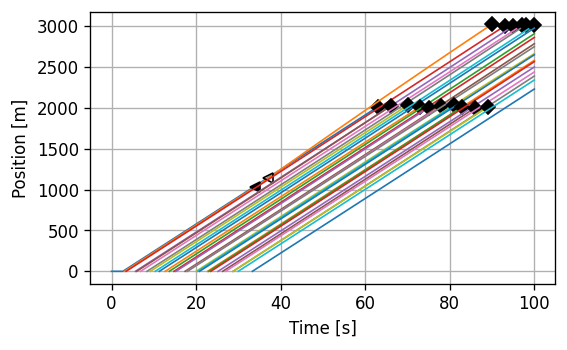

In [16]:
rec.plot('t', 'x')

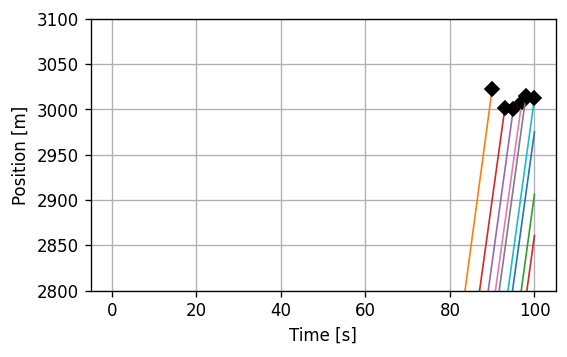

In [17]:
rec.plot('t', 'x', ymin=2800, ymax=3100)

## Traffic Flow in veh/h

The traffic flow at the end of lane segments for the **left lane**:

In [ ]:
rec.flow(6), rec.flow(7) #rec.flow(4)

(1252.17, 1200.0)

The traffic flow at the end of lane segments for the **right lane**:

In [ ]:
rec.flow(3), rec.flow(4), rec.flow(5)

(431.84, 432.0, 450.0)

The traffic flow at the end of lane segments for the **centre lane**:

In [ ]:
rec.flow(0), rec.flow(1), rec.flow(2)

(564.71, 564.71, 635.29)

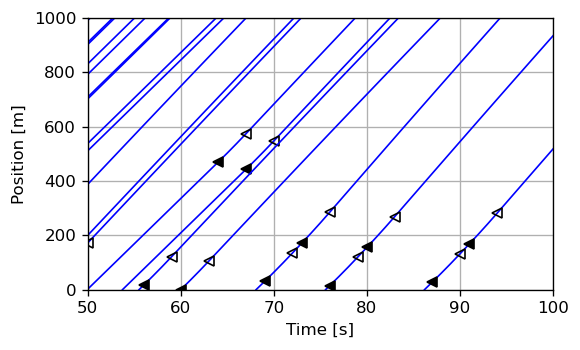

In [ ]:
rec.plot('t', 'x', xmin=50, xmax=100, ymin=0, ymax=1000, style='b')

## Traffic Density in veh/km

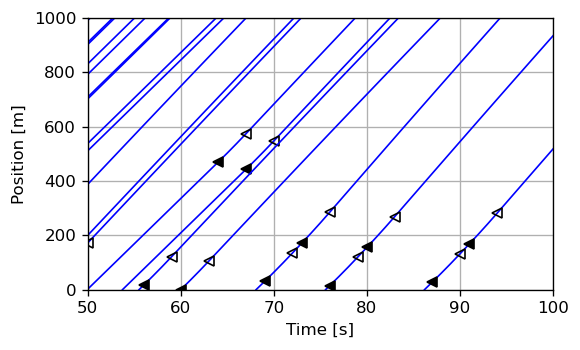

In [ ]:
rec.plot('t', 'x', xmin=50, xmax=100, ymin=0, ymax=1000, style='b')

In [ ]:
#The statistics reports:
print(rec.density(0, 50) + rec.density(1, 50)+rec.density(2, 50))
print(rec.density(3, 50) + rec.density(4, 50)+rec.density(5, 50))
print(rec.density(6, 50) + rec.density(7, 50))

## Average Travel Times in s

In [ ]:
rec.avgTravelTime(0)

## Average Speed in km/h

In [ ]:
rec.avgSpeed(0)

## Fundamental Law

In [ ]:
rec.density(0, 50)*rec.avgSpeed(0) + rec.density(3, 50)*rec.avgSpeed(3)

## Testing Simulation with different Vehicle types

## Part 1

Case 1

1000 Vehicles, 300 in left Lane, 400 in center lane and 300 in Right Lane

Inter-Arrival Time Distributions = 3 sec for each lane

Traffic Mix = 45% of "Car", 20% of "Electric Car", 35% of " heavy goods vehicles"

Motorway speed Limit Setting = 120Km/h = 120/3.6 m/s



In [20]:
import random
VMAX = 120/3.6

N_l = 300 # number of vehicles in the left lane 
IAT_l = 3 # average interarrival time left lane

N_c = 400 # number of vehicles in the central lane 
IAT_c = 3 # average interarrival time central lane

N_r = 300 # number of vehicles in the right lane 
IAT_r = 3 # average interarrival time right lane

random.seed(13)

iat_l = [ rv(IAT_l, delta=0.4*IAT_l) for i in range(N_l) ]
iat_r = [ rv(IAT_r, delta=0.4*IAT_r) for i in range(N_r) ]
iat_c = [ rv(IAT_c, delta=0.4*IAT_c) for i in range(N_c) ]

rec = Recorder(0, 200, 1)



c = Lane(rec, 1700)
c1 = Lane(rec,300)
c2= Lane(rec, 1000)
c.extend(c1)
c.extend(c2)


r = Lane(rec, 1700)
r1 = Lane(rec,300)
r2= Lane(rec, 1000)
r.extend(r1)
r.extend(r2)
c.attachRight(r)

#r = c.widenRight()
l = Lane(rec, 1700)
mergeLane = Lane(rec, 300, merge='R')
l.extend(mergeLane)
c.attachLeft(l)



# c = Lane(rec, 1000)
# c1 = Lane(rec,700)
# c2= Lane(rec, 300)
# c3= Lane(rec, 1000)

# c.extend(c1)
# c.extend(c2)
# c.extend(c3)



# r = Lane(rec, 1000)
# r1 = Lane(rec,700)
# r2= Lane(rec, 300)
# r3= Lane(rec, 1000)

# r.extend(r1)
# r.extend(r2)
# r.extend(r3)

# c.attachRight(r)


# #r = c.widenRight()




# l = Lane(rec, 1000)
# l1 = Lane(rec, 700)
# l.extend(l1)

# mergeLane = Lane(rec, 300, merge='R')
# l.extend(mergeLane)

# c.attachLeft(l)

print("L:", l)
print("C:", c)
print("R:", r)


#for right
t=0    
for i in range(N_r):
    t += iat_r[i]
    v = Vehicle(rec, startingLane=r, t0=t, dx0=VMAX,vmax=VMAX)


t = 0
# fill left lane
for i in range(N_l):
    t += iat_l[i]
#    v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)

    r=random.random()
    if r<=0.2:
        v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='electric car')
    elif r<=0.55:
        v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='HGV')    
    else:
        v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)
        

        
        
        
# fill centre lane
t=0
for i in range(N_c):
    t += iat_c[i]
#    v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)

    r=random.random()
    if r<=0.2:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='electric car')
    elif r<=0.55:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='HGV')    
    else:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)
    


    
rec.run()

L: [06 x=0.0m l=1700.0m L:-- R:00]-[07 x=1700.0m l=300.0m L:-- R:--]\
C: [00 x=0.0m l=1700.0m L:06 R:03]-[01 x=1700.0m l=300.0m L:-- R:--]-[02 x=2000.0m l=1000.0m L:-- R:--]
R: [03 x=0.0m l=1700.0m L:00 R:--]-[04 x=1700.0m l=300.0m L:-- R:--]-[05 x=2000.0m l=1000.0m L:-- R:--]


In [21]:
rec.getData()

,t,x,v,a,id,lane,oldLane,pos,event,Vehicle
0,0,0,0,0,0,0,-1,1700,lane info,No vehicle yet
1,0,0,0,0,0,1,-1,300,lane info,No vehicle yet
2,0,0,0,0,0,2,-1,1000,lane info,No vehicle yet
3,0,0,0,0,0,3,-1,1700,lane info,No vehicle yet
4,0,0,0,0,0,4,-1,300,lane info,No vehicle yet
...,...,...,...,...,...,...,...,...,...,...
40298,500,21.29,33.3337,0.00109344,166,3,-1,21.29,timer,car
40299,500.118,3000.72,34.3195,0.00520195,137,5,-1,1000.72,leave lane,car
40300,500.118,3000.72,34.3195,0.00520195,137,-1,-1,1000.72,end,car
40301,500.846,0,33.3333,0,768,-1,-1,0,start,HGV


In [ ]:
rec.data['Vehicle'].unique()

array(['No vehicle yet', 'car', 'HGV', 'electric car'], dtype=object)

**Save Case_1 Data**

In [22]:
rec.saveData("case_1.csv")

### Statistics of self organising motorway scenarios

### Before Merging at 1700m

In [23]:
# rec.flow(6)+rec.flow(7)
# rec.flow(0)+ rec.flow(1)+ rec.flow(2)
# rec.flow(3)+ rec.flow(4)+ rec.flow(5)


# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 1700m )****************************")
print("The traffic Volume at 1700m the left lane : ", rec.flow(6))
print(" The traffic Volume at 1700m the right lane :", rec.flow(3))
print(" The traffic Volume at 1700m the centre lane", rec.flow(0))
print(" \n The traffic Volume at 1700m in all lane", rec.flow(0)+ rec.flow(3)+rec.flow(6))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 1700m the left lane : ", rec.density(6, 50))
print(" The traffic density at 1700m the right lane :", rec.density(3, 50))
print(" The traffic density at 1700m the centre lane", rec.density(0, 50))
print(" \nThe traffic density at 1700m in all lane", rec.density(6, 50)+ rec.density(0, 50)+ rec.density(3, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 1700m the left lane :", rec.avgTravelTime(6))
print("Average Travel travel at 1700m the right lane :", rec.avgTravelTime(3))
print("Average Travel travel at 1700m the centre lane :", rec.avgTravelTime(0))
print("\nAverage Travel travel at 1700m in all lane :", (rec.avgTravelTime(0)+ rec.avgTravelTime(6)+ rec.avgTravelTime(3))/3)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 1700m the left lane :", rec.avgSpeed(6))
print("Average speed at the 1700m the right lane :", rec.avgSpeed(3))
print("Average speed at the 1700m the centre lane :", rec.avgSpeed(0))
print("Average speed at the 1700m the all lane :", (rec.avgSpeed(0)+ rec.avgSpeed(3)+ rec.avgSpeed(6))/3)

***************************** After 1700m (1KM)****************************
The traffic Volume at 1700m the left lane :  1221.69
 The traffic Volume at 1700m the right lane : 1210.84
 The traffic Volume at 1700m the centre lane 1224.32
 
 The traffic Volume at 1700m in all lane 3656.85

 ----------------------------------------------------
The traffic density at 1700m the left lane :  10.0
 The traffic density at 1700m the right lane : 8.82
 The traffic density at 1700m the centre lane 9.41
 
The traffic density at 1700m in all lane 28.23

 ----------------------------------------------------
Average Travel travel at 1700m the left lane : 51.25
Average Travel travel at 1700m the right lane : 51.29
Average Travel travel at 1700m the centre lane : 51.26

Average Travel travel at 1700m in all lane : 51.26666666666666

 ----------------------------------------------------
Average speed at the 1700m the left lane : 119.41
Average speed at the 1700m the right lane : 119.32
Average speed at t

### After Merging 3 lane to 2 lane at 2000m

In [24]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 2000m (****************************\n")
print("The traffic Volume at 2000m the left lane : ", rec.flow(7))
print(" The traffic Volume at 2000m the right lane :", rec.flow(4))
print(" The traffic Volume at 2000m the centre lane", rec.flow(1))
print(" \n The traffic Volume at 2000m in all lane", rec.flow(7)+ rec.flow(1)+rec.flow(4))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 2000m the left lane : ", rec.density(7, 100))
print(" The traffic density at 2000m the right lane :", rec.density(4, 100))
print(" The traffic density at 2000m the centre lane", rec.density(1, 100))
print(" \nThe traffic density at 2000m in all lane", rec.density(1, 100)+ rec.density(7, 100)+ rec.density(4, 100))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 2000m the left lane :", rec.avgTravelTime(7))
print("Average Travel travel at 2000m the right lane :", rec.avgTravelTime(4))
print("Average Travel travel at 2000m the centre lane :", rec.avgTravelTime(1))
print("\nAverage Travel travel at 2000m in all lane :", (rec.avgTravelTime(1)+ rec.avgTravelTime(4)+ rec.avgTravelTime(7))/3)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 2000m the left lane :", rec.avgSpeed(7))
print("Average speed at the 2000m the right lane :", rec.avgSpeed(4))
print("Average speed at the 2000m the centre lane :", rec.avgSpeed(1))
print("Average speed at the 2000m the all lane :", (rec.avgSpeed(1)+ rec.avgSpeed(4)+ rec.avgSpeed(7))/3)

***************************** After 2000m (****************************

The traffic Volume at 2000m the left lane :  1219.22
 The traffic Volume at 2000m the right lane : 1211.06
 The traffic Volume at 2000m the centre lane 1222.02
 
 The traffic Volume at 2000m in all lane 3652.2999999999997

 ----------------------------------------------------
The traffic density at 2000m the left lane :  10.0
 The traffic density at 2000m the right lane : 10.0
 The traffic density at 2000m the centre lane 10.0
 
The traffic density at 2000m in all lane 30.0

 ----------------------------------------------------
Average Travel travel at 2000m the left lane : 8.98
Average Travel travel at 2000m the right lane : 8.99
Average Travel travel at 2000m the centre lane : 8.99

Average Travel travel at 2000m in all lane : 8.986666666666666

 ----------------------------------------------------
Average speed at the 2000m the left lane : 120.27
Average speed at the 2000m the right lane : 120.13
Average speed 

### At the end of the motorway section at 3000m

In [26]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 3000m (****************************\n")

print(" The traffic Volume at 3000m the right lane :", rec.flow(5))
print(" The traffic Volume at 3000m the centre lane", rec.flow(2))
print(" \n The traffic Volume at 3000m in all lane", rec.flow(2)+ rec.flow(5))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print(" The traffic density at 3000m the right lane :", rec.density(5, 50))
print(" The traffic density at 3000m the centre lane", rec.density(2, 50))
print(" \nThe traffic density at 3000m in all lane", rec.density(5, 50)+ rec.density(2, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 3000m the right lane :", rec.avgTravelTime(5))
print("Average Travel travel at 3000m the centre lane :", rec.avgTravelTime(2))
print("\nAverage Travel travel at 3000m in all lane :", (rec.avgTravelTime(5)+ rec.avgTravelTime(2))/2)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 3000m the right lane :", rec.avgSpeed(5))
print("Average speed at the 3000m the centre lane :", rec.avgSpeed(2))
print("Average speed at the 3000m the all lane :", (rec.avgSpeed(5)+ rec.avgSpeed(2))/2)

***************************** After 3000m (****************************

 The traffic Volume at 3000m the right lane : 1214.43
 The traffic Volume at 3000m the centre lane 1226.67
 
 The traffic Volume at 3000m in all lane 2441.1000000000004

 ----------------------------------------------------
 The traffic density at 3000m the right lane : 0.0
 The traffic density at 3000m the centre lane 0.0
 
The traffic density at 3000m in all lane 0.0

 ----------------------------------------------------
Average Travel travel at 3000m the right lane : 29.67
Average Travel travel at 3000m the centre lane : 29.65

Average Travel travel at 3000m in all lane : 29.66

 ----------------------------------------------------
Average speed at the 3000m the right lane : 121.33
Average speed at the 3000m the centre lane : 121.42
Average speed at the 3000m the all lane : 121.375


##Case 2

1000 Vehicles, 300 in left Lane, 400 in center lane and 300 in Right Lane

Inter-Arrival Time Distributions = 15 sec for each lane

Traffic Mix = 60% of "Car", 30% of "Electric Car", 10% of " heavy goods vehicles"

Motorway speed Limit Setting = 80Km/h = 80/3.6 m/s



In [31]:
import random
VMAX = 80/3.6

N_l = 300 # number of vehicles in the left lane 
IAT_l = 15 # average interarrival time left lane

N_c = 400 # number of vehicles in the central lane 
IAT_c = 15 # average interarrival time central lane

N_r = 300 # number of vehicles in the right lane 
IAT_r = 15 # average interarrival time right lane

random.seed(13)

iat_l = [ rv(IAT_l, delta=0.4*IAT_l) for i in range(N_l) ]
iat_r = [ rv(IAT_r, delta=0.4*IAT_r) for i in range(N_r) ]
iat_c = [ rv(IAT_c, delta=0.4*IAT_c) for i in range(N_c) ]

rec = Recorder(0, 500, 1)



c = Lane(rec, 1700)
c1 = Lane(rec,300)
c2= Lane(rec, 1000)
c.extend(c1)
c.extend(c2)


r = Lane(rec, 1700)
r1 = Lane(rec,300)
r2= Lane(rec, 1000)
r.extend(r1)
r.extend(r2)
c.attachRight(r)

#r = c.widenRight()
l = Lane(rec, 1700)
mergeLane = Lane(rec, 300, merge='R')
l.extend(mergeLane)
c.attachLeft(l)

print("L:", l)
print("C:", c)
print("R:", r)


#for right
t=0    
for i in range(N_r):
    t += iat_r[i]
    v = Vehicle(rec, startingLane=r, t0=t, dx0=VMAX,vmax=VMAX)


t = 0
# fill left lane
for i in range(N_l):
    t += iat_l[i]
#    v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)

    r=random.random()
    if r<=0.2:
        v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='electric car')
    elif r<=0.55:
        v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='HGV')    
    else:
        v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)
        

        
        
        
# fill centre lane
t=0
for i in range(N_c):
    t += iat_c[i]
#    v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)

    r=random.random()
    if r<=0.2:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='electric car')
    elif r<=0.55:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='HGV')    
    else:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)
    


    
rec.run()

L: [06 x=0.0m l=1700.0m L:-- R:00]-[07 x=1700.0m l=300.0m L:-- R:--]\
C: [00 x=0.0m l=1700.0m L:06 R:03]-[01 x=1700.0m l=300.0m L:-- R:--]-[02 x=2000.0m l=1000.0m L:-- R:--]
R: [03 x=0.0m l=1700.0m L:00 R:--]-[04 x=1700.0m l=300.0m L:-- R:--]-[05 x=2000.0m l=1000.0m L:-- R:--]


In [32]:
rec.getData()

,t,x,v,a,id,lane,oldLane,pos,event,Vehicle
0,0,0,0,0,0,0,-1,1700,lane info,No vehicle yet
1,0,0,0,0,0,1,-1,300,lane info,No vehicle yet
2,0,0,0,0,0,2,-1,1000,lane info,No vehicle yet
3,0,0,0,0,0,3,-1,1700,lane info,No vehicle yet
4,0,0,0,0,0,4,-1,300,lane info,No vehicle yet
...,...,...,...,...,...,...,...,...,...,...
4202,500,1400.58,22.3767,0.00266866,328,6,-1,1400.58,timer,HGV
4203,500,1026.96,22.3427,0.00290008,329,6,-1,1026.96,timer,HGV
4204,500,682.46,22.2618,0.0015751,330,6,-1,682.46,timer,car
4205,500,358.9,22.2579,0.00295813,331,6,-1,358.9,timer,electric car


In [ ]:
rec.data['Vehicle'].unique()

array(['No vehicle yet', 'car', 'HGV', 'electric car'], dtype=object)

**Save Case_1 Data**

In [75]:
rec.saveData("Case_2.csv")

### Statistics of self organising motorway scenarios

### Before Merging at 1700m

In [34]:
# rec.flow(6)+rec.flow(7)
# rec.flow(0)+ rec.flow(1)+ rec.flow(2)
# rec.flow(3)+ rec.flow(4)+ rec.flow(5)


# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 1700m )****************************")
print("The traffic Volume at 1700m the left lane : ", rec.flow(6))
print(" The traffic Volume at 1700m the right lane :", rec.flow(3))
print(" The traffic Volume at 1700m the centre lane", rec.flow(0))
print(" \n The traffic Volume at 1700m in all lane", rec.flow(0)+ rec.flow(3)+rec.flow(6))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 1700m the left lane : ", rec.density(6, 50))
print(" The traffic density at 1700m the right lane :", rec.density(3, 50))
print(" The traffic density at 1700m the centre lane", rec.density(0, 50))
print(" \nThe traffic density at 1700m in all lane", rec.density(6, 50)+ rec.density(0, 50)+ rec.density(3, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 1700m the left lane :", rec.avgTravelTime(6))
print("Average Travel travel at 1700m the right lane :", rec.avgTravelTime(3))
print("Average Travel travel at 1700m the centre lane :", rec.avgTravelTime(0))
print("\nAverage Travel travel at 1700m in all lane :", (rec.avgTravelTime(0)+ rec.avgTravelTime(6)+ rec.avgTravelTime(3))/3)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 1700m the left lane :", rec.avgSpeed(6))
print("Average speed at the 1700m the right lane :", rec.avgSpeed(3))
print("Average speed at the 1700m the centre lane :", rec.avgSpeed(0))
print("Average speed at the 1700m the all lane :", (rec.avgSpeed(0)+ rec.avgSpeed(3)+ rec.avgSpeed(6))/3)

***************************** After 1700m )****************************
The traffic Volume at 1700m the left lane :  273.07
 The traffic Volume at 1700m the right lane : 0
 The traffic Volume at 1700m the centre lane 207.69
 
 The traffic Volume at 1700m in all lane 480.76

 ----------------------------------------------------
The traffic density at 1700m the left lane :  2.94
 The traffic density at 1700m the right lane : 0.59
 The traffic density at 1700m the centre lane 1.18
 
The traffic density at 1700m in all lane 4.71

 ----------------------------------------------------
Average Travel travel at 1700m the left lane : 76.61
Average Travel travel at 1700m the right lane : 76.54
Average Travel travel at 1700m the centre lane : 76.73

Average Travel travel at 1700m in all lane : 76.62666666666667

 ----------------------------------------------------
Average speed at the 1700m the left lane : 79.89
Average speed at the 1700m the right lane : 79.96
Average speed at the 1700m the cen

### After Merging 3 lane to 2 lane at 2000m

In [35]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 2000m (****************************\n")
print("The traffic Volume at 2000m the left lane : ", rec.flow(7))
print(" The traffic Volume at 2000m the right lane :", rec.flow(4))
print(" The traffic Volume at 2000m the centre lane", rec.flow(1))
print(" \n The traffic Volume at 2000m in all lane", rec.flow(7)+ rec.flow(1)+rec.flow(4))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 2000m the left lane : ", rec.density(7, 100))
print(" The traffic density at 2000m the right lane :", rec.density(4, 100))
print(" The traffic density at 2000m the centre lane", rec.density(1, 100))
print(" \nThe traffic density at 2000m in all lane", rec.density(1, 100)+ rec.density(7, 100)+ rec.density(4, 100))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 2000m the left lane :", rec.avgTravelTime(7))
print("Average Travel travel at 2000m the right lane :", rec.avgTravelTime(4))
print("Average Travel travel at 2000m the centre lane :", rec.avgTravelTime(1))
print("\nAverage Travel travel at 2000m in all lane :", (rec.avgTravelTime(1)+ rec.avgTravelTime(4)+ rec.avgTravelTime(7))/3)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 2000m the left lane :", rec.avgSpeed(7))
print("Average speed at the 2000m the right lane :", rec.avgSpeed(4))
print("Average speed at the 2000m the centre lane :", rec.avgSpeed(1))
print("Average speed at the 2000m the all lane :", (rec.avgSpeed(1)+ rec.avgSpeed(4)+ rec.avgSpeed(7))/3)

***************************** After 2000m (****************************

The traffic Volume at 2000m the left lane :  275.4
 The traffic Volume at 2000m the right lane : 0
 The traffic Volume at 2000m the centre lane 203.77
 
 The traffic Volume at 2000m in all lane 479.16999999999996

 ----------------------------------------------------
The traffic density at 2000m the left lane :  6.67
 The traffic density at 2000m the right lane : 3.33
 The traffic density at 2000m the centre lane 3.33
 
The traffic density at 2000m in all lane 13.33

 ----------------------------------------------------
Average Travel travel at 2000m the left lane : 13.23
Average Travel travel at 2000m the right lane : 14.0
Average Travel travel at 2000m the centre lane : 13.5

Average Travel travel at 2000m in all lane : 13.576666666666668

 ----------------------------------------------------
Average speed at the 2000m the left lane : 81.63
Average speed at the 2000m the right lane : 77.14
Average speed at the 2

### At the end of the motorway section at 3000m

In [36]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 3000m (****************************\n")

print(" The traffic Volume at 3000m the right lane :", rec.flow(5))
print(" The traffic Volume at 3000m the centre lane", rec.flow(2))
print(" \n The traffic Volume at 3000m in all lane", rec.flow(2)+ rec.flow(5))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print(" The traffic density at 3000m the right lane :", rec.density(5, 50))
print(" The traffic density at 3000m the centre lane", rec.density(2, 50))
print(" \nThe traffic density at 3000m in all lane", rec.density(5, 50)+ rec.density(2, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 3000m the right lane :", rec.avgTravelTime(5))
print("Average Travel travel at 3000m the centre lane :", rec.avgTravelTime(2))
print("\nAverage Travel travel at 3000m in all lane :", (rec.avgTravelTime(5)+ rec.avgTravelTime(2))/2)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 3000m the right lane :", rec.avgSpeed(5))
print("Average speed at the 3000m the centre lane :", rec.avgSpeed(2))
print("Average speed at the 3000m the all lane :", (rec.avgSpeed(5)+ rec.avgSpeed(2))/2)

***************************** After 3000m (****************************

 The traffic Volume at 3000m the right lane : 0
 The traffic Volume at 3000m the centre lane 200.0
 
 The traffic Volume at 3000m in all lane 200.0

 ----------------------------------------------------
 The traffic density at 3000m the right lane : 0.0
 The traffic density at 3000m the centre lane 0.0
 
The traffic density at 3000m in all lane 0.0

 ----------------------------------------------------
Average Travel travel at 3000m the right lane : 44.0
Average Travel travel at 3000m the centre lane : 44.75

Average Travel travel at 3000m in all lane : 44.375

 ----------------------------------------------------
Average speed at the 3000m the right lane : 81.82
Average speed at the 3000m the centre lane : 80.45
Average speed at the 3000m the all lane : 81.13499999999999


##Case 3

1000 Vehicles, 300 in left Lane, 400 in center lane and 300 in Right Lane

Inter-Arrival Time Distributions = 10 sec for each lane

Traffic Mix = 65% of "Car", 15% of "Electric Car", 20% of " heavy goods vehicles"

Motorway speed Limit Setting = 100Km/h = 80/3.6 m/s



In [37]:
import random
VMAX = 100/3.6

N_l = 300 # number of vehicles in the left lane 
IAT_l = 10 # average interarrival time left lane

N_c = 400 # number of vehicles in the central lane 
IAT_c = 10 # average interarrival time central lane

N_r = 300 # number of vehicles in the right lane 
IAT_r = 10 # average interarrival time right lane

random.seed(13)

iat_l = [ rv(IAT_l, delta=0.4*IAT_l) for i in range(N_l) ]
iat_r = [ rv(IAT_r, delta=0.4*IAT_r) for i in range(N_r) ]
iat_c = [ rv(IAT_c, delta=0.4*IAT_c) for i in range(N_c) ]

rec = Recorder(0, 500, 1)



c = Lane(rec, 1700)
c1 = Lane(rec,300)
c2= Lane(rec, 1000)
c.extend(c1)
c.extend(c2)


r = Lane(rec, 1700)
r1 = Lane(rec,300)
r2= Lane(rec, 1000)
r.extend(r1)
r.extend(r2)
c.attachRight(r)

#r = c.widenRight()
l = Lane(rec, 1700)
mergeLane = Lane(rec, 300, merge='R')
l.extend(mergeLane)
c.attachLeft(l)

print("L:", l)
print("C:", c)
print("R:", r)


#for right
t=0    
for i in range(N_r):
    t += iat_r[i]
    v = Vehicle(rec, startingLane=r, t0=t, dx0=VMAX,vmax=VMAX)


t = 0
# fill left lane
for i in range(N_l):
    t += iat_l[i]
#    v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)

    r=random.random()
    if r<=0.2:
        v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='electric car')
    elif r<=0.55:
        v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='HGV')    
    else:
        v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)
        

        
        
        
# fill centre lane
t=0
for i in range(N_c):
    t += iat_c[i]
#    v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)

    r=random.random()
    if r<=0.2:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='electric car')
    elif r<=0.55:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='HGV')    
    else:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)
    


    
rec.run()

L: [06 x=0.0m l=1700.0m L:-- R:00]-[07 x=1700.0m l=300.0m L:-- R:--]\
C: [00 x=0.0m l=1700.0m L:06 R:03]-[01 x=1700.0m l=300.0m L:-- R:--]-[02 x=2000.0m l=1000.0m L:-- R:--]
R: [03 x=0.0m l=1700.0m L:00 R:--]-[04 x=1700.0m l=300.0m L:-- R:--]-[05 x=2000.0m l=1000.0m L:-- R:--]


In [38]:
rec.getData()

,t,x,v,a,id,lane,oldLane,pos,event,Vehicle
0,0,0,0,0,0,0,-1,1700,lane info,No vehicle yet
1,0,0,0,0,0,1,-1,300,lane info,No vehicle yet
2,0,0,0,0,0,2,-1,1000,lane info,No vehicle yet
3,0,0,0,0,0,3,-1,1700,lane info,No vehicle yet
4,0,0,0,0,0,4,-1,300,lane info,No vehicle yet
...,...,...,...,...,...,...,...,...,...,...
8330,500,752.85,27.8661,0.00412972,346,6,-1,752.85,timer,car
8331,500,471.98,27.8616,0.00651828,347,6,-1,471.98,timer,HGV
8332,500,224.51,27.8177,0.00988397,348,6,-1,224.51,timer,car
8333,500,1,27.7647,-0.723315,649,0,-1,1,timer,car


In [ ]:
rec.data['Vehicle'].unique()

array(['No vehicle yet', 'car', 'HGV', 'electric car'], dtype=object)

**Save Case_1 Data**

In [76]:
rec.saveData("Case_3.csv")

### Statistics of self organising motorway scenarios

### Before Merging at 1700m

In [40]:
# rec.flow(6)+rec.flow(7)
# rec.flow(0)+ rec.flow(1)+ rec.flow(2)
# rec.flow(3)+ rec.flow(4)+ rec.flow(5)


# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 1700m )****************************")
print("The traffic Volume at 1700m the left lane : ", rec.flow(6))
print(" The traffic Volume at 1700m the right lane :", rec.flow(3))
print(" The traffic Volume at 1700m the centre lane", rec.flow(0))
print(" \n The traffic Volume at 1700m in all lane", rec.flow(0)+ rec.flow(3)+rec.flow(6))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 1700m the left lane : ", rec.density(6, 50))
print(" The traffic density at 1700m the right lane :", rec.density(3, 50))
print(" The traffic density at 1700m the centre lane", rec.density(0, 50))
print(" \nThe traffic density at 1700m in all lane", rec.density(6, 50)+ rec.density(0, 50)+ rec.density(3, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 1700m the left lane :", rec.avgTravelTime(6))
print("Average Travel travel at 1700m the right lane :", rec.avgTravelTime(3))
print("Average Travel travel at 1700m the centre lane :", rec.avgTravelTime(0))
print("\nAverage Travel travel at 1700m in all lane :", (rec.avgTravelTime(0)+ rec.avgTravelTime(6)+ rec.avgTravelTime(3))/3)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 1700m the left lane :", rec.avgSpeed(6))
print("Average speed at the 1700m the right lane :", rec.avgSpeed(3))
print("Average speed at the 1700m the centre lane :", rec.avgSpeed(0))
print("Average speed at the 1700m the all lane :", (rec.avgSpeed(0)+ rec.avgSpeed(3)+ rec.avgSpeed(6))/3)

***************************** After 1700m )****************************
The traffic Volume at 1700m the left lane :  354.1
 The traffic Volume at 1700m the right lane : 298.09
 The traffic Volume at 1700m the centre lane 222.35
 
 The traffic Volume at 1700m in all lane 874.54

 ----------------------------------------------------
The traffic density at 1700m the left lane :  2.94
 The traffic density at 1700m the right lane : 1.76
 The traffic density at 1700m the centre lane 2.94
 
The traffic density at 1700m in all lane 7.64

 ----------------------------------------------------
Average Travel travel at 1700m the left lane : 62.18
Average Travel travel at 1700m the right lane : 61.37
Average Travel travel at 1700m the centre lane : 61.41

Average Travel travel at 1700m in all lane : 61.653333333333336

 ----------------------------------------------------
Average speed at the 1700m the left lane : 98.42
Average speed at the 1700m the right lane : 99.72
Average speed at the 1700m th

### After Merging 3 lane to 2 lane at 2000m

In [41]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 2000m (****************************\n")
print("The traffic Volume at 2000m the left lane : ", rec.flow(7))
print(" The traffic Volume at 2000m the right lane :", rec.flow(4))
print(" The traffic Volume at 2000m the centre lane", rec.flow(1))
print(" \n The traffic Volume at 2000m in all lane", rec.flow(7)+ rec.flow(1)+rec.flow(4))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 2000m the left lane : ", rec.density(7, 100))
print(" The traffic density at 2000m the right lane :", rec.density(4, 100))
print(" The traffic density at 2000m the centre lane", rec.density(1, 100))
print(" \nThe traffic density at 2000m in all lane", rec.density(1, 100)+ rec.density(7, 100)+ rec.density(4, 100))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 2000m the left lane :", rec.avgTravelTime(7))
print("Average Travel travel at 2000m the right lane :", rec.avgTravelTime(4))
print("Average Travel travel at 2000m the centre lane :", rec.avgTravelTime(1))
print("\nAverage Travel travel at 2000m in all lane :", (rec.avgTravelTime(1)+ rec.avgTravelTime(4)+ rec.avgTravelTime(7))/3)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 2000m the left lane :", rec.avgSpeed(7))
print("Average speed at the 2000m the right lane :", rec.avgSpeed(4))
print("Average speed at the 2000m the centre lane :", rec.avgSpeed(1))
print("Average speed at the 2000m the all lane :", (rec.avgSpeed(1)+ rec.avgSpeed(4)+ rec.avgSpeed(7))/3)

***************************** After 2000m (****************************

The traffic Volume at 2000m the left lane :  353.11
 The traffic Volume at 2000m the right lane : 298.09
 The traffic Volume at 2000m the centre lane 221.7
 
 The traffic Volume at 2000m in all lane 872.8999999999999

 ----------------------------------------------------
The traffic density at 2000m the left lane :  3.33
 The traffic density at 2000m the right lane : 3.33
 The traffic density at 2000m the centre lane 6.67
 
The traffic density at 2000m in all lane 13.33

 ----------------------------------------------------
Average Travel travel at 2000m the left lane : 10.69
Average Travel travel at 2000m the right lane : 10.92
Average Travel travel at 2000m the centre lane : 10.67

Average Travel travel at 2000m in all lane : 10.76

 ----------------------------------------------------
Average speed at the 2000m the left lane : 101.03
Average speed at the 2000m the right lane : 98.9
Average speed at the 2000m th

### At the end of the motorway section at 3000m

In [42]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 3000m (****************************\n")

print(" The traffic Volume at 3000m the right lane :", rec.flow(5))
print(" The traffic Volume at 3000m the centre lane", rec.flow(2))
print(" \n The traffic Volume at 3000m in all lane", rec.flow(2)+ rec.flow(5))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print(" The traffic density at 3000m the right lane :", rec.density(5, 50))
print(" The traffic density at 3000m the centre lane", rec.density(2, 50))
print(" \nThe traffic density at 3000m in all lane", rec.density(5, 50)+ rec.density(2, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 3000m the right lane :", rec.avgTravelTime(5))
print("Average Travel travel at 3000m the centre lane :", rec.avgTravelTime(2))
print("\nAverage Travel travel at 3000m in all lane :", (rec.avgTravelTime(5)+ rec.avgTravelTime(2))/2)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 3000m the right lane :", rec.avgSpeed(5))
print("Average speed at the 3000m the centre lane :", rec.avgSpeed(2))
print("Average speed at the 3000m the all lane :", (rec.avgSpeed(5)+ rec.avgSpeed(2))/2)

***************************** After 3000m (****************************

 The traffic Volume at 3000m the right lane : 298.09
 The traffic Volume at 3000m the centre lane 220.41
 
 The traffic Volume at 3000m in all lane 518.5

 ----------------------------------------------------
 The traffic density at 3000m the right lane : 0.0
 The traffic density at 3000m the centre lane 0.0
 
The traffic density at 3000m in all lane 0.0

 ----------------------------------------------------
Average Travel travel at 3000m the right lane : 35.46
Average Travel travel at 3000m the centre lane : 35.08

Average Travel travel at 3000m in all lane : 35.269999999999996

 ----------------------------------------------------
Average speed at the 3000m the right lane : 101.52
Average speed at the 3000m the centre lane : 102.62
Average speed at the 3000m the all lane : 102.07


# Part 2 Vehicle Type with Driver behaviour 

In [43]:
free_speed = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170 ]
quantiles = np.cumsum([0, 0.002, 0.015, 0.025, 0.178, 0.372, 0.390, 0.119
, 0.148, 0.03, 0.001])
def random_speed():
  u = random.random() # uniformly distributed random number generated between 0 and 1
  for i in range(len(quantiles)):
    if u<quantiles[i+1]:
      p = (u-quantiles[i])/(quantiles[i+1]-quantiles[i])
      return free_speed[i]*p+free_speed[i+1]*(1-p)

In [44]:
import random
random.seed(0)
speeds = [ random_speed() for i in range(210000)]
kernel = stats.gaussian_kde(speeds)

In [45]:
v1 = np.arange(60, 170) #generate spread out from 60 170
q1 = [ kernel.integrate_box_1d(30, i) for i in v1 ]
def freeMotorwaySpeed():
  u = random.random() # generates uniformly distributed random number between 0 and 1
  for i in range(len(q1)):
    if u<q1[i+1]:
      p1 = (u-q1[i])/(q1[i+1]-q1[i])
      # return (free_speed[i+1]+free_speed[i])/2*p+(1-p)*(free_speed[i+1]+free_speed[i+2])/2
      return v1[i]*p1+v1[i+1]*(1-p1)


freeMotorwaySpeed()


84.19903863508866

In [46]:
free_speed_bins = [ 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]
free_speed_quantiles = np.cumsum([0, 0.006, 0.014, 0.052, 0.148, 0.27, 0.309, 0.143, 0.048, 0.01])

def free_speed_distribution():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(free_speed_quantiles)):
        if u<free_speed_quantiles[i+1]:
            p = (u-free_speed_quantiles[i])/(free_speed_quantiles[i+1]-free_speed_quantiles[i])
            return free_speed_bins[i]*p+free_speed_bins[i+1]*(1-p)
        
free_speed_data = [ free_speed_distribution() for i in range(1200)]
free_speed_kernel = stats.gaussian_kde(free_speed_data)

free_speeds = np.arange(30, 191)
free_speed_cdf = [ free_speed_kernel.integrate_box_1d(30, i) for i in free_speeds ]

def random_free_speed():
    u = random.random() # generates uniformly distributed random number between 0 and 1
    for i in range(len(free_speeds)):
        if u<free_speed_cdf[i+1]:
            p = (u-free_speed_cdf[i])/(free_speed_cdf[i+1]-free_speed_cdf[i])
            return free_speeds[i]*p+free_speeds[i+1]*(1-p)

In [47]:
speeds = [ random_free_speed() for i in range(100000) ]

In [48]:
def VehiclePlusDriverType(HGV, electric, car, autonomous = 0, d_behaviour=1):
  w = random.random()
 
  if w <= autonomous:
    vdrivers = 'Human'
  else:
    vdrivers = 'auto'

  d = random.random()
  if d < d_behaviour:
    behaviour = 'normal'
  elif d > d_behaviour:
    behaviour = 'drunk'
  else:
    behaviour='rash'
    
  vFAR_AWAY_IN_FRONT = 200
  vFAR_AWAY_IN_BACK = 80
    
  u = random.random()
  if u <= HGV:
    vtype = 'HGV'
    vstartspeed = freeMotorwaySpeed()/3.6 #### vstartspeed = freeMotorwaySpeedLorry()/3.6
    vlength = 15
    va_max = 0.96
 
    if vdrivers == 'Human':
        if behaviour== "drunk":
            # fixed 0.4 difference for drunk
            va_min = -1.28 + 0.125*random.random()
        elif behaviour == "normal":
            va_min = -0.88 + 0.125*random.random()
        elif behaviour == "rash":
            # fixed 0.25 difference for rash
            va_min = -0.63 + 0.125*random.random()
      
    
    else:
      va_min = -0.88
      vFAR_AWAY_IN_FRONT = 200
      vFAR_AWAY_IN_BACK = 110

  elif u <= HGV + electric: #######??????
    vtype = 'Electric Car'
    vstartspeed = freeMotorwaySpeed()/3.6
    vlength = 6
    va_max = 2.47
    if vdrivers =='Human':
         if behaviour== "drunk":
            va_min = -4.37 + 0.5*random.random()
         elif behaviour == "normal":
            va_min = -3.97 + 0.5*random.random()
         elif behaviour == "rash":
            va_min = -3.72 + 0.125*random.random()
    
    else:
      va_min = -3.97
      vFAR_AWAY_IN_FRONT = 200
      vFAR_AWAY_IN_BACK = 80
  else:
    vtype = 'Car'
    vstartspeed = freeMotorwaySpeed()/3.6
    vlength = 4
    va_max = 2.47
    if vdrivers == 'Human':
        if behaviour== "drunk":
            va_min = -2.15 + 0.4*random.random()
        elif behaviour == "normal":
            va_min = -2.55 + 0.4**random.random()
        elif behaviour == "rash":
            va_min = -2.8 + 0.125*random.random()
    
    else:
      va_min = -3.97
      vFAR_AWAY_IN_FRONT = 200
      vFAR_AWAY_IN_BACK = 80

  return vtype, vstartspeed, vlength, va_max, va_min, vFAR_AWAY_IN_FRONT, vFAR_AWAY_IN_BACK, vdrivers, behaviour


In [49]:
SLOW_CYCLE = 100

def randomIntervals(cycles):
  # return [ random.expovariate(1.0/SLOW_CYCLE)+10 for i in range(cycles) ]
  return [ max(0, random.normalvariate(SLOW_CYCLE, SLOW_CYCLE/3)) for i in range(cycles) ]

In [50]:
def cyc(): # random element to cycles
  cycles = 5 + round(5*(random.random()))
  return cycles
cyc()


10

In [51]:
SPEED_VARIATION = 0.05 #To get an idea about the time intervals and the speed approached we look at the first few random values:
random.seed(13)

def randomSpeedVariation(vmax, cycles, cv=SPEED_VARIATION):
  return [ vmax + (-1)**i*abs(random.normalvariate(0, vmax*cv)) for i in range(cycles) ]


# Simulation of Part 2

## Case 4


Number of Vehicles = 1000

Inter-Arrival Time Distributions = 3 sec for each lane

Traffic Mix = 45% of "Car", 20% of "Electric Car", 35% of " heavy goods vehicles"

Motorway speed Limit Setting = 120Km/h = 120/3.6 m/s

with driver behaviour "Drunk", "Rash", "Normal"

In [52]:
VMAX = 120/3.6 
N = 1000 # number of points
IAT = 3 # average interarrival time
random.seed(13)
env = simpy.Environment()
rec = Recorder(0, 500, 1)
iat = [ rv(IAT, delta=0.4*IAT) for i in range(N) ]

#iat = [ random.expovariate(1.0/IAT) for i in range(N) ]

c = Lane(rec, 1700)
c1 = Lane(rec,300)
c2= Lane(rec, 1000)
c.extend(c1)
c.extend(c2)


r = Lane(rec, 1700)
r1 = Lane(rec,300)
r2= Lane(rec, 1000)
r.extend(r1)
r.extend(r2)
c.attachRight(r)

#r = c.widenRight()
l = Lane(rec, 1700)
mergeLane = Lane(rec, 300, merge='R')
l.extend(mergeLane)
c.attachLeft(l)


random.seed()
vehicles = []

#...
for i in range(1000):   
  r = VehiclePlusDriverType(0.35, 0.20, 0.45, 0.5, 0.4)
  vehicles.append(r)
  i+=1 


t0 = 0
for i in range(N):
  CYCLES = cyc
  CYCLES = random.randint(4, 8) #the parametre is an element of list
  times = randomIntervals(CYCLES)
  speed = randomSpeedVariation(vehicles[i][1], CYCLES) #each car has a speed caracteristic gv by the firs element of car
  t0 += iat[i]+10 #REFLECT A CAR IN FONT
  
  CAR_LENGTH = vehicles[i][2]
  va_max = vehicles[i][3] #the max acceleration is gv each care in the list
  va_min = vehicles[i][4]
#  print(i, CAR_LENGTH, vehicles[i][1], vehicles[i][0], vehicles[i][8], t0, iat[i], 3*(vehicles[i-1][2] /vehicles[i-1][1]))
    
  print(i,"vType = ", vehicles[i][0], "   ", "V_Length = ", CAR_LENGTH, "   ", "Start_V = ", vehicles[i][1], "   ", "driver_behaivour = ", vehicles[i][8])
  FAR_AWAY_IN_FRONT = 200
  FAR_AWAY_IN_BACK = 200


t=0
for i in range(N):
    t += iat[i]
    r=random.random()
    if r<=0.2:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='electric car')
    elif r<=0.55:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='HGV')    
    else:
        v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5)


#  v = Vehicle(rec, startingLane=l, t0=t0, dx0=speed[-1], t=times, v=speed, VEHICLE_MODEL='electric car')
#   v = Vehicle(rec, startingLane=c, t0=t0, dx0=speed[-1], t=times, v=speed, VEHICLE_MODEL='car')
#   v = Vehicle(rec, startingLane=r, t0=t0, dx0=speed[-1], t=times, v=speed, VEHICLE_MODEL='HGV')
#  v = traceOvertake = True

rec.run() 

0 vType =  HGV     V_Length =  15     Start_V =  33.33312584731595     driver_behaivour =  normal
1 vType =  Car     V_Length =  4     Start_V =  25.989117265652094     driver_behaivour =  drunk
2 vType =  Car     V_Length =  4     Start_V =  33.081441783232215     driver_behaivour =  drunk
3 vType =  HGV     V_Length =  15     Start_V =  31.921730947696286     driver_behaivour =  drunk
4 vType =  Car     V_Length =  4     Start_V =  27.997881436968697     driver_behaivour =  normal
5 vType =  Car     V_Length =  4     Start_V =  26.324515734201977     driver_behaivour =  drunk
6 vType =  Car     V_Length =  4     Start_V =  29.697371485191653     driver_behaivour =  drunk
7 vType =  Car     V_Length =  4     Start_V =  28.127033986742482     driver_behaivour =  drunk
8 vType =  HGV     V_Length =  15     Start_V =  32.22267611719082     driver_behaivour =  normal
9 vType =  HGV     V_Length =  15     Start_V =  32.669840830774824     driver_behaivour =  normal
10 vType =  HGV     V_Le

In [53]:
rec.getEvents()

,t,x,v,a,id,lane,oldLane,pos,event,Vehicle
0,0,0,0,0,0,0,-1,1700,lane info,No vehicle yet
1,0,0,0,0,0,1,-1,300,lane info,No vehicle yet
2,0,0,0,0,0,2,-1,1000,lane info,No vehicle yet
3,0,0,0,0,0,3,-1,1700,lane info,No vehicle yet
4,0,0,0,0,0,4,-1,300,lane info,No vehicle yet
...,...,...,...,...,...,...,...,...,...,...
12990,498.888,1710.04,33.5282,0.00416242,151,1,-1,10.04,enter lane,HGV
13016,499,3.73,33.3333,0.000109425,169,0,-1,3.73,change slow,HGV
13017,499,3.73,33.3333,0.000109425,169,6,0,3.73,enter lane 6,HGV
13043,500,192.33,33.3334,3.87641e-05,167,0,-1,192.33,change slow,HGV


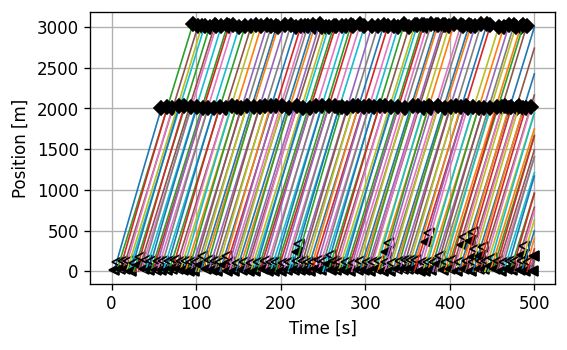

In [54]:
rec.plot('t', 'x')

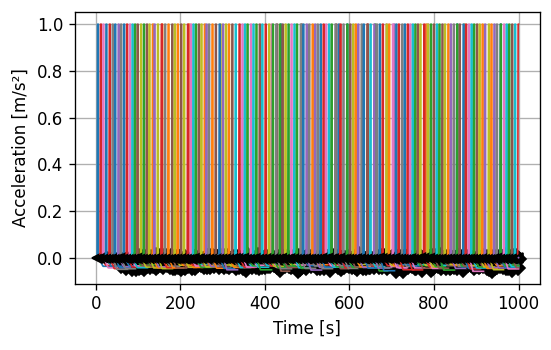

In [ ]:
rec.plot('t', 'a')

### Statistics of self organising motorway scenarios

### Before Merging at 1700m

In [55]:
# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 1700m (****************************")
print("The traffic Volume at 1700m the left lane : ", rec.flow(6))
print(" The traffic Volume at 1700m the right lane :", rec.flow(3))
print(" The traffic Volume at 1700m the centre lane", rec.flow(0))
print(" \n The traffic Volume at 1700m in all lane", rec.flow(0)+ rec.flow(3)+rec.flow(6))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 1700m the left lane : ", rec.density(6, 50))
print(" The traffic density at 1700m the right lane :", rec.density(3, 50))
print(" The traffic density at 1700m the centre lane", rec.density(0, 50))
print(" \nThe traffic density at 1700m in all lane", rec.density(6, 50)+ rec.density(0, 50)+ rec.density(3, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 1700m the left lane :", rec.avgTravelTime(6))
print("Average Travel travel at 1700m the right lane :", rec.avgTravelTime(3))
print("Average Travel travel at 1700m the centre lane :", rec.avgTravelTime(0))
print("\nAverage Travel travel at 1700m in all lane :", (rec.avgTravelTime(0)+ rec.avgTravelTime(6)+ rec.avgTravelTime(3))/3)

print("\n ----------------------------------------------------")


***************************** After 1700m (1KM)****************************
The traffic Volume at 1700m the left lane :  560.72
 The traffic Volume at 1700m the right lane : 0
 The traffic Volume at 1700m the centre lane 659.9
 
 The traffic Volume at 1700m in all lane 1220.62

 ----------------------------------------------------
The traffic density at 1700m the left lane :  4.12
 The traffic density at 1700m the right lane : 0.0
 The traffic density at 1700m the centre lane 5.88
 
The traffic density at 1700m in all lane 10.0

 ----------------------------------------------------
Average Travel travel at 1700m the left lane : 0
Average Travel travel at 1700m the right lane : 0
Average Travel travel at 1700m the centre lane : 51.25

Average Travel travel at 1700m in all lane : 17.083333333333332

 ----------------------------------------------------


### After Merging 3 lane to 2 lane at 2000m

In [56]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 2000m (****************************\n")
print("The traffic Volume at 2000m the left lane : ", rec.flow(7))
print(" The traffic Volume at 2000m the right lane :", rec.flow(4))
print(" The traffic Volume at 2000m the centre lane", rec.flow(1))
print(" \n The traffic Volume at 2000m in all lane", rec.flow(7)+ rec.flow(1)+rec.flow(4))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 2000m the left lane : ", rec.density(7, 100))
print(" The traffic density at 2000m the right lane :", rec.density(4, 100))
print(" The traffic density at 2000m the centre lane", rec.density(1, 100))
print(" \nThe traffic density at 2000m in all lane", rec.density(1, 100)+ rec.density(7, 100)+ rec.density(4, 100))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 2000m the left lane :", rec.avgTravelTime(7))
print("Average Travel travel at 2000m the right lane :", rec.avgTravelTime(4))
print("Average Travel travel at 2000m the centre lane :", rec.avgTravelTime(1))
print("\nAverage Travel travel at 2000m in all lane :", (rec.avgTravelTime(1)+ rec.avgTravelTime(4)+ rec.avgTravelTime(7))/3)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 2000m the left lane :", rec.avgSpeed(7))
#print("Average speed at the 2000m the right lane :", rec.avgSpeed(4))
print("Average speed at the 2000m the centre lane :", rec.avgSpeed(1))
#print("Average speed at the 2000m the all lane :", (rec.avgSpeed(1)+ rec.avgSpeed(4)+ rec.avgSpeed(7))/3)

***************************** After 2000m (****************************

The traffic Volume at 2000m the left lane :  560.18
 The traffic Volume at 2000m the right lane : 0
 The traffic Volume at 2000m the centre lane 661.4
 
 The traffic Volume at 2000m in all lane 1221.58

 ----------------------------------------------------
The traffic density at 2000m the left lane :  6.67
 The traffic density at 2000m the right lane : 0.0
 The traffic density at 2000m the centre lane 6.67
 
The traffic density at 2000m in all lane 13.34

 ----------------------------------------------------
Average Travel travel at 2000m the left lane : 8.62
Average Travel travel at 2000m the right lane : 0
Average Travel travel at 2000m the centre lane : 9.0

Average Travel travel at 2000m in all lane : 5.873333333333332

 ----------------------------------------------------
Average speed at the 2000m the left lane : 125.29
Average speed at the 2000m the centre lane : 120.0


### At the end of the motorway section at 3000m

In [57]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 3000m (****************************\n")

print(" The traffic Volume at 3000m the right lane :", rec.flow(5))
print(" The traffic Volume at 3000m the centre lane", rec.flow(2))
print(" \n The traffic Volume at 3000m in all lane", rec.flow(2)+ rec.flow(5))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print(" The traffic density at 3000m the right lane :", rec.density(5, 50))
print(" The traffic density at 3000m the centre lane", rec.density(2, 50))
print(" \nThe traffic density at 3000m in all lane", rec.density(5, 50)+ rec.density(2, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 3000m the right lane :", rec.avgTravelTime(5))
print("Average Travel travel at 3000m the centre lane :", rec.avgTravelTime(2))
print("\nAverage Travel travel at 3000m in all lane :", (rec.avgTravelTime(5)+ rec.avgTravelTime(2))/2)

print("\n ----------------------------------------------------")

# Average Speed 

#print("Average speed at the 3000m the right lane :", rec.avgSpeed(5))
print("Average speed at the 3000m the centre lane :", rec.avgSpeed(2))
#print("Average speed at the 3000m the all lane :", (rec.avgSpeed(5)+ rec.avgSpeed(2))/2)

***************************** After 3000m (****************************

 The traffic Volume at 3000m the right lane : 0
 The traffic Volume at 3000m the centre lane 683.54
 
 The traffic Volume at 3000m in all lane 683.54

 ----------------------------------------------------
 The traffic density at 3000m the right lane : 0.0
 The traffic density at 3000m the centre lane 0.0
 
The traffic density at 3000m in all lane 0.0

 ----------------------------------------------------
Average Travel travel at 3000m the right lane : 0
Average Travel travel at 3000m the centre lane : 29.65

Average Travel travel at 3000m in all lane : 14.825

 ----------------------------------------------------
Average speed at the 3000m the centre lane : 121.42


In [58]:
rec.saveData("Case_4.csv")

## Case 5


Number of Vehicles = 1000

Inter-Arrival Time Distributions = 15 sec for each lane

Traffic Mix = 60% of "Car", 30% of "Electric Car", 10% of " heavy goods vehicles"

Motorway speed Limit Setting = 80Km/h = 60/3.6 m/s

With driver behaviour "Drunk", "Rash", "Normal"

In [59]:
VMAX = 80/3.6 # car SUV & LMV
N = 1000 # number of points
IAT = 15 # average interarrival time
random.seed(13)
env = simpy.Environment()
rec = Recorder(0, 1000, 1)
iat = [ rv(IAT, delta=0.4*IAT) for i in range(N) ]

#iat = [ random.expovariate(1.0/IAT) for i in range(N) ]

c = Lane(rec, 1700, speedLimit=80)
c1 = Lane(rec,300, speedLimit=80)
c2= Lane(rec, 1000, speedLimit=80)
c.extend(c1)
c.extend(c2)


r = Lane(rec, 1700, speedLimit=80)
r1 = Lane(rec,300, speedLimit=80)
r2= Lane(rec, 1000, speedLimit=80)
r.extend(r1)
r.extend(r2)
c.attachRight(r)

#r = c.widenRight()
l = Lane(rec, 1700, speedLimit=80)
mergeLane = Lane(rec, 300, merge='R')
l.extend(mergeLane)
c.attachLeft(l)


random.seed()
vehicles = []

#generation for 1000 vehicle
for i in range(1000):   
  r = VehiclePlusDriverType(0.10, 0.30, 0.60, 0.6, 0.7)
  vehicles.append(r)
  i+=1 


t0 = 0
for i in range(N):
  CYCLES = cyc
  CYCLES = random.randint(4, 8) #the parametre is an element of list
  times = randomIntervals(CYCLES)
  speed = randomSpeedVariation(vehicles[i][1], CYCLES) #each car has a speed caracteristic gv by the firs element of car
  t0 += iat[i]+10 #REFLECT A CAR IN FONT
  
  CAR_LENGTH = vehicles[i][2]
  va_max = vehicles[i][3] #the max acceleration is gv each care in the list
  va_min = vehicles[i][4]
#  print(i, CAR_LENGTH, vehicles[i][1], vehicles[i][0], vehicles[i][8], t0, iat[i], 3*(vehicles[i-1][2] /vehicles[i-1][1]))
    
  print(i,"vType = ", vehicles[i][0], "    ", "V_Length = ", CAR_LENGTH, "   ", "Start_V = ", vehicles[i][1], "    ", "driver_behaivour = ", vehicles[i][8])
  FAR_AWAY_IN_FRONT = 200
  FAR_AWAY_IN_BACK = 200




t=0
for i in range(N//3):
    t += iat[i]
    v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='electric car')
t=0
for i in range(N//3):
    t += iat[i]
    v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='HGV')


for i in range(N//3):
    t += iat[i]
    v = Vehicle(rec, startingLane=r, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='car')

rec.run() 

0 vType =  Car      V_Length =  4     Start_V =  26.17151476775279      driver_behaivour =  normal
1 vType =  Electric Car      V_Length =  6     Start_V =  25.3612442728306      driver_behaivour =  drunk
2 vType =  Car      V_Length =  4     Start_V =  31.03902841395996      driver_behaivour =  normal
3 vType =  Car      V_Length =  4     Start_V =  29.057216792454327      driver_behaivour =  normal
4 vType =  Car      V_Length =  4     Start_V =  33.167281325437564      driver_behaivour =  normal
5 vType =  Electric Car      V_Length =  6     Start_V =  33.323083478527444      driver_behaivour =  normal
6 vType =  Car      V_Length =  4     Start_V =  28.667841625903282      driver_behaivour =  normal
7 vType =  Electric Car      V_Length =  6     Start_V =  31.32363108233273      driver_behaivour =  normal
8 vType =  Electric Car      V_Length =  6     Start_V =  30.266698173192957      driver_behaivour =  normal
9 vType =  Electric Car      V_Length =  6     Start_V =  28.957706203

In [60]:
rec.getEvents()

,t,x,v,a,id,lane,oldLane,pos,event,Vehicle
0,0,0,0,0,0,0,-1,1700,lane info,No vehicle yet
1,0,0,0,0,0,1,-1,300,lane info,No vehicle yet
2,0,0,0,0,0,2,-1,1000,lane info,No vehicle yet
3,0,0,0,0,0,3,-1,1700,lane info,No vehicle yet
4,0,0,0,0,0,4,-1,300,lane info,No vehicle yet
...,...,...,...,...,...,...,...,...,...,...
14089,999.569,0,22.2222,0,399,6,-1,0,enter lane,HGV
14090,999.569,1702.04,25.0266,-0.0211011,61,6,-1,1702.04,leave lane,electric car
14091,999.569,1702.04,25.0266,-0.0211011,61,7,-1,2.04,enter lane,electric car
14092,1000,3001.38,22.3157,0.0113774,57,2,-1,1001.38,leave lane,electric car


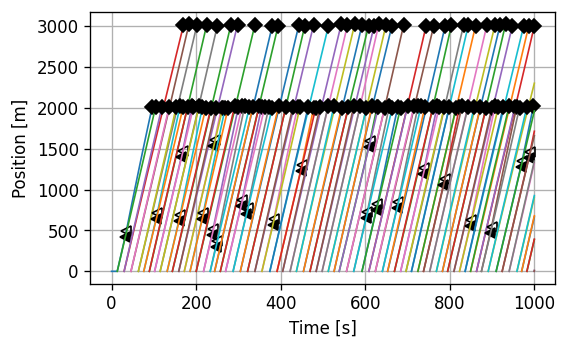

In [61]:
rec.plot('t', 'x')

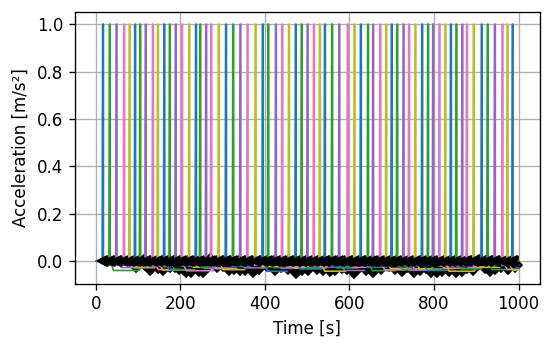

In [ ]:
rec.plot('t', 'a')

### Before Merging at 1700m

In [62]:
# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 1700m (1KM)****************************")
print("The traffic Volume at 1700m the left lane : ", rec.flow(6))
print(" The traffic Volume at 1700m the right lane :", rec.flow(3))
print(" The traffic Volume at 1700m the centre lane", rec.flow(0))
print(" \n The traffic Volume at 1700m in all lane", rec.flow(0)+ rec.flow(3)+rec.flow(6))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 1700m the left lane : ", rec.density(6, 50))
print(" The traffic density at 1700m the right lane :", rec.density(3, 50))
print(" The traffic density at 1700m the centre lane", rec.density(0, 50))
print(" \nThe traffic density at 1700m in all lane", rec.density(6, 50)+ rec.density(0, 50)+ rec.density(3, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 1700m the left lane :", rec.avgTravelTime(6))
print("Average Travel travel at 1700m the right lane :", rec.avgTravelTime(3))
print("Average Travel travel at 1700m the centre lane :", rec.avgTravelTime(0))
print("\nAverage Travel travel at 1700m in all lane :", (rec.avgTravelTime(0)+ rec.avgTravelTime(6)+ rec.avgTravelTime(3))/3)

print("\n ----------------------------------------------------")


***************************** After 1700m (1KM)****************************
The traffic Volume at 1700m the left lane :  322.42
 The traffic Volume at 1700m the right lane : 0
 The traffic Volume at 1700m the centre lane 162.88
 
 The traffic Volume at 1700m in all lane 485.3

 ----------------------------------------------------
The traffic density at 1700m the left lane :  2.35
 The traffic density at 1700m the right lane : 0.0
 The traffic density at 1700m the centre lane 1.18
 
The traffic density at 1700m in all lane 3.5300000000000002

 ----------------------------------------------------
Average Travel travel at 1700m the left lane : 77.3
Average Travel travel at 1700m the right lane : 0
Average Travel travel at 1700m the centre lane : 77.76

Average Travel travel at 1700m in all lane : 51.68666666666667

 ----------------------------------------------------


### After Merging 3 lane to 2 lane at 2000m

In [63]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 2000m (****************************\n")
print("The traffic Volume at 2000m the left lane : ", rec.flow(7))
print(" The traffic Volume at 2000m the right lane :", rec.flow(4))
print(" The traffic Volume at 2000m the centre lane", rec.flow(1))
print(" \n The traffic Volume at 2000m in all lane", rec.flow(7)+ rec.flow(1)+rec.flow(4))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 2000m the left lane : ", rec.density(7, 100))
print(" The traffic density at 2000m the right lane :", rec.density(4, 100))
print(" The traffic density at 2000m the centre lane", rec.density(1, 100))
print(" \nThe traffic density at 2000m in all lane", rec.density(1, 100)+ rec.density(7, 100)+ rec.density(4, 100))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 2000m the left lane :", rec.avgTravelTime(7))
print("Average Travel travel at 2000m the right lane :", rec.avgTravelTime(4))
print("Average Travel travel at 2000m the centre lane :", rec.avgTravelTime(1))
print("\nAverage Travel travel at 2000m in all lane :", (rec.avgTravelTime(1)+ rec.avgTravelTime(4)+ rec.avgTravelTime(7))/3)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 2000m the left lane :", rec.avgSpeed(7))
#print("Average speed at the 2000m the right lane :", rec.avgSpeed(4))
print("Average speed at the 2000m the centre lane :", rec.avgSpeed(1))
#print("Average speed at the 2000m the all lane :", (rec.avgSpeed(1)+ rec.avgSpeed(4)+ rec.avgSpeed(7))/3)

***************************** After 2000m (****************************

The traffic Volume at 2000m the left lane :  319.29
 The traffic Volume at 2000m the right lane : 0
 The traffic Volume at 2000m the centre lane 162.69
 
 The traffic Volume at 2000m in all lane 481.98

 ----------------------------------------------------
The traffic density at 2000m the left lane :  3.33
 The traffic density at 2000m the right lane : 0.0
 The traffic density at 2000m the centre lane 0.0
 
The traffic density at 2000m in all lane 3.33

 ----------------------------------------------------
Average Travel travel at 2000m the left lane : 13.12
Average Travel travel at 2000m the right lane : 0
Average Travel travel at 2000m the centre lane : 13.76

Average Travel travel at 2000m in all lane : 8.959999999999999

 ----------------------------------------------------
Average speed at the 2000m the left lane : 82.32
Average speed at the 2000m the centre lane : 78.49


### At the end of the motorway section at 3000m

In [64]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 3000m (****************************\n")

print(" The traffic Volume at 3000m the right lane :", rec.flow(5))
print(" The traffic Volume at 3000m the centre lane", rec.flow(2))
print(" \n The traffic Volume at 3000m in all lane", rec.flow(2)+ rec.flow(5))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print(" The traffic density at 3000m the right lane :", rec.density(5, 50))
print(" The traffic density at 3000m the centre lane", rec.density(2, 50))
print(" \nThe traffic density at 3000m in all lane", rec.density(5, 50)+ rec.density(2, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 3000m the right lane :", rec.avgTravelTime(5))
print("Average Travel travel at 3000m the centre lane :", rec.avgTravelTime(2))
print("\nAverage Travel travel at 3000m in all lane :", (rec.avgTravelTime(5)+ rec.avgTravelTime(2))/2)

print("\n ----------------------------------------------------")

# Average Speed 

#print("Average speed at the 3000m the right lane :", rec.avgSpeed(5))
print("Average speed at the 3000m the centre lane :", rec.avgSpeed(2))
#print("Average speed at the 3000m the all lane :", (rec.avgSpeed(5)+ rec.avgSpeed(2))/2)

***************************** After 3000m (****************************

 The traffic Volume at 3000m the right lane : 0
 The traffic Volume at 3000m the centre lane 164.82
 
 The traffic Volume at 3000m in all lane 164.82

 ----------------------------------------------------
 The traffic density at 3000m the right lane : 0.0
 The traffic density at 3000m the centre lane 0.0
 
The traffic density at 3000m in all lane 0.0

 ----------------------------------------------------
Average Travel travel at 3000m the right lane : 0
Average Travel travel at 3000m the centre lane : 45.67

Average Travel travel at 3000m in all lane : 22.835

 ----------------------------------------------------
Average speed at the 3000m the centre lane : 78.83


In [65]:
rec.saveData("Case_5.csv")

## Case 6


Number of Vehicles = 1000

Inter-Arrival Time Distributions = 10 sec for each lane

Traffic Mix = 65% of "Car", 15% of "Electric Car", 20% of " heavy goods vehicles"

Motorway speed Limit Setting = 100Km/h = 100/3.6 m/s

With driver behaviour "Drunk", "Rash", "Normal"

In [66]:
VMAX = 100/3.6 # car SUV & LMV
N = 1000 # number of points
IAT = 10 # average interarrival time
random.seed(13)
env = simpy.Environment()
rec = Recorder(0, 1000, 1)
iat = [ rv(IAT, delta=0.4*IAT) for i in range(N) ]

#iat = [ random.expovariate(1.0/IAT) for i in range(N) ]

c = Lane(rec, 1700, speedLimit=80)
c1 = Lane(rec,300, speedLimit=80)
c2= Lane(rec, 1000, speedLimit=80)
c.extend(c1)
c.extend(c2)


r = Lane(rec, 1700, speedLimit=80)
r1 = Lane(rec,300, speedLimit=80)
r2= Lane(rec, 1000, speedLimit=80)
r.extend(r1)
r.extend(r2)
c.attachRight(r)

#r = c.widenRight()
l = Lane(rec, 1700, speedLimit=80)
mergeLane = Lane(rec, 300, merge='R')
l.extend(mergeLane)
c.attachLeft(l)


random.seed()
vehicles = []

#generation for 1000 vehicle
for i in range(1000):   
  r = VehiclePlusDriverType(0.20, 0.15, 0.65, 0.4, 0.7)
  vehicles.append(r)
  i+=1 


t0 = 0
for i in range(N):
  CYCLES = cyc
  CYCLES = random.randint(4, 8) #the parametre is an element of list
  times = randomIntervals(CYCLES)
  speed = randomSpeedVariation(vehicles[i][1], CYCLES) #each car has a speed caracteristic gv by the firs element of car
  t0 += iat[i]+10 #REFLECT A CAR IN FONT
  
  CAR_LENGTH = vehicles[i][2]
  va_max = vehicles[i][3] #the max acceleration is gv each care in the list
  va_min = vehicles[i][4]
#  print(i, CAR_LENGTH, vehicles[i][1], vehicles[i][0], vehicles[i][8], t0, iat[i], 3*(vehicles[i-1][2] /vehicles[i-1][1]))
    
  print(i,"vType = ", vehicles[i][0], "    ", "V_Length = ", CAR_LENGTH, "   ", "Start_V = ", vehicles[i][1], "    ", "driver_behaivour = ", vehicles[i][8])
  FAR_AWAY_IN_FRONT = 200
  FAR_AWAY_IN_BACK = 200


t=0
for i in range(N//3):
    t += iat[i]
    v = Vehicle(rec, startingLane=c, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='electric car')
t=0
for i in range(N//3):
    t += iat[i]
    v = Vehicle(rec, startingLane=l, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='HGV')


for i in range(N//3):
    t += iat[i]
    v = Vehicle(rec, startingLane=r, t0=t, dx0=VMAX, vmax=VMAX,a_max=2.5, VEHICLE_MODEL='car')



#  v = Vehicle(rec, startingLane=l, t0=t0, dx0=speed[-1], t=times, v=speed, VEHICLE_MODEL='electric car')
#   v = Vehicle(rec, startingLane=c, t0=t0, dx0=speed[-1], t=times, v=speed, VEHICLE_MODEL='car')
#   v = Vehicle(rec, startingLane=r, t0=t0, dx0=speed[-1], t=times, v=speed, VEHICLE_MODEL='HGV')
#  v = traceOvertake = True

rec.run() 

0 vType =  Car      V_Length =  4     Start_V =  27.773524337709166      driver_behaivour =  normal
1 vType =  Car      V_Length =  4     Start_V =  31.53108333137426      driver_behaivour =  normal
2 vType =  Car      V_Length =  4     Start_V =  29.953890617375027      driver_behaivour =  normal
3 vType =  HGV      V_Length =  15     Start_V =  32.37856338628255      driver_behaivour =  drunk
4 vType =  Electric Car      V_Length =  6     Start_V =  32.90991555837099      driver_behaivour =  normal
5 vType =  Car      V_Length =  4     Start_V =  30.579777365534003      driver_behaivour =  normal
6 vType =  Car      V_Length =  4     Start_V =  31.24660583325683      driver_behaivour =  drunk
7 vType =  Electric Car      V_Length =  6     Start_V =  30.984666764736804      driver_behaivour =  normal
8 vType =  Car      V_Length =  4     Start_V =  30.714690934692328      driver_behaivour =  drunk
9 vType =  Car      V_Length =  4     Start_V =  33.15957685948528      driver_behaivour

In [67]:
rec.getEvents()

,t,x,v,a,id,lane,oldLane,pos,event,Vehicle
0,0,0,0,0,0,0,-1,1700,lane info,No vehicle yet
1,0,0,0,0,0,1,-1,300,lane info,No vehicle yet
2,0,0,0,0,0,2,-1,1000,lane info,No vehicle yet
3,0,0,0,0,0,3,-1,1700,lane info,No vehicle yet
4,0,0,0,0,0,4,-1,300,lane info,No vehicle yet
...,...,...,...,...,...,...,...,...,...,...
21234,999,2019.06,27.7806,0.000530889,423,-1,-1,319.06,end,HGV
21235,999,1704.84,22.4387,0.0019956,91,0,-1,1704.84,leave lane,electric car
21236,999,1704.84,22.4387,0.0019956,91,1,-1,4.84,enter lane,electric car
21238,999,1703.68,21.5736,-0.0206269,424,6,-1,1703.68,leave lane,HGV


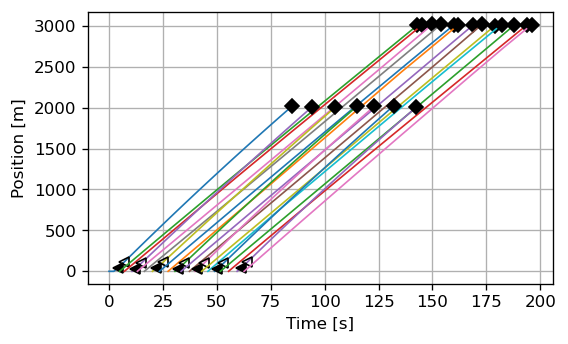

In [ ]:
rec.plot('t', 'x')

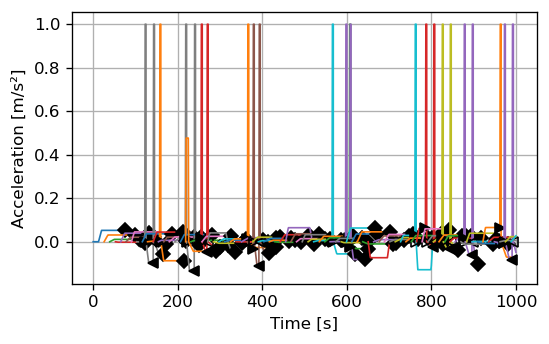

In [ ]:
rec.plot('t', 'a')

### Statistics of self organising motorway scenarios

### Before Merging at 1700m

In [68]:
# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 1700m (1KM)****************************")
print("The traffic Volume at 1700m the left lane : ", rec.flow(6))
print(" The traffic Volume at 1700m the right lane :", rec.flow(3))
print(" The traffic Volume at 1700m the centre lane", rec.flow(0))
print(" \n The traffic Volume at 1700m in all lane", rec.flow(0)+ rec.flow(3)+rec.flow(6))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 1700m the left lane : ", rec.density(6, 50))
print(" The traffic density at 1700m the right lane :", rec.density(3, 50))
print(" The traffic density at 1700m the centre lane", rec.density(0, 50))
print(" \nThe traffic density at 1700m in all lane", rec.density(6, 50)+ rec.density(0, 50)+ rec.density(3, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 1700m the left lane :", rec.avgTravelTime(6))
print("Average Travel travel at 1700m the right lane :", rec.avgTravelTime(3))
print("Average Travel travel at 1700m the centre lane :", rec.avgTravelTime(0))
print("\nAverage Travel travel at 1700m in all lane :", (rec.avgTravelTime(0)+ rec.avgTravelTime(6)+ rec.avgTravelTime(3))/3)

print("\n ----------------------------------------------------")


***************************** After 1700m (1KM)****************************
The traffic Volume at 1700m the left lane :  441.14
 The traffic Volume at 1700m the right lane : 0
 The traffic Volume at 1700m the centre lane 275.71
 
 The traffic Volume at 1700m in all lane 716.8499999999999

 ----------------------------------------------------
The traffic density at 1700m the left lane :  2.35
 The traffic density at 1700m the right lane : 0.0
 The traffic density at 1700m the centre lane 2.35
 
The traffic density at 1700m in all lane 4.7

 ----------------------------------------------------
Average Travel travel at 1700m the left lane : 77.15
Average Travel travel at 1700m the right lane : 0
Average Travel travel at 1700m the centre lane : 77.03

Average Travel travel at 1700m in all lane : 51.39333333333334

 ----------------------------------------------------


### After Merging 3 lane to 2 lane at 2000m

In [70]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 2000m (****************************\n")
print("The traffic Volume at 2000m the left lane : ", rec.flow(7))
print(" The traffic Volume at 2000m the right lane :", rec.flow(4))
print(" The traffic Volume at 2000m the centre lane", rec.flow(1))
print(" \n The traffic Volume at 2000m in all lane", rec.flow(7)+ rec.flow(1)+rec.flow(4))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print("The traffic density at 2000m the left lane : ", rec.density(7, 100))
print(" The traffic density at 2000m the right lane :", rec.density(4, 100))
print(" The traffic density at 2000m the centre lane", rec.density(1, 100))
print(" \nThe traffic density at 2000m in all lane", rec.density(1, 100)+ rec.density(7, 100)+ rec.density(4, 100))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 2000m the left lane :", rec.avgTravelTime(7))
print("Average Travel travel at 2000m the right lane :", rec.avgTravelTime(4))
print("Average Travel travel at 2000m the centre lane :", rec.avgTravelTime(1))
print("\nAverage Travel travel at 2000m in all lane :", (rec.avgTravelTime(1)+ rec.avgTravelTime(4)+ rec.avgTravelTime(7))/3)

print("\n ----------------------------------------------------")

# Average Speed 

print("Average speed at the 2000m the left lane :", rec.avgSpeed(7))
#print("Average speed at the 2000m the right lane :", rec.avgSpeed(4))
print("Average speed at the 2000m the centre lane :", rec.avgSpeed(1))
#print("Average speed at the 2000m the all lane :", (rec.avgSpeed(1)+ rec.avgSpeed(4)+ rec.avgSpeed(7))/3)

***************************** After 2000m (****************************

The traffic Volume at 2000m the left lane :  442.52
 The traffic Volume at 2000m the right lane : 0
 The traffic Volume at 2000m the centre lane 275.99
 
 The traffic Volume at 2000m in all lane 718.51

 ----------------------------------------------------
The traffic density at 2000m the left lane :  3.33
 The traffic density at 2000m the right lane : 0.0
 The traffic density at 2000m the centre lane 3.33
 
The traffic density at 2000m in all lane 6.66

 ----------------------------------------------------
Average Travel travel at 2000m the left lane : 11.04
Average Travel travel at 2000m the right lane : 0
Average Travel travel at 2000m the centre lane : 13.56

Average Travel travel at 2000m in all lane : 8.200000000000001

 ----------------------------------------------------
Average speed at the 2000m the left lane : 97.83
Average speed at the 2000m the centre lane : 79.65


### At the end of the motorway section at 3000m

In [71]:

# The traffic Volume at the end of lane segments for the different lanes (veh/hr):

print("***************************** After 3000m (****************************\n")

print(" The traffic Volume at 3000m the right lane :", rec.flow(5))
print(" The traffic Volume at 3000m the centre lane", rec.flow(2))
print(" \n The traffic Volume at 3000m in all lane", rec.flow(2)+ rec.flow(5))

print("\n ----------------------------------------------------")
# Traffic Density at the end of lane segments for the different lanes (veh/km):

print(" The traffic density at 3000m the right lane :", rec.density(5, 50))
print(" The traffic density at 3000m the centre lane", rec.density(2, 50))
print(" \nThe traffic density at 3000m in all lane", rec.density(5, 50)+ rec.density(2, 50))

print("\n ----------------------------------------------------")
# Average travel time:

print("Average Travel travel at 3000m the right lane :", rec.avgTravelTime(5))
print("Average Travel travel at 3000m the centre lane :", rec.avgTravelTime(2))
print("\nAverage Travel travel at 3000m in all lane :", (rec.avgTravelTime(5)+ rec.avgTravelTime(2))/2)

print("\n ----------------------------------------------------")

# Average Speed 

#print("Average speed at the 3000m the right lane :", rec.avgSpeed(5))
print("Average speed at the 3000m the centre lane :", rec.avgSpeed(2))
#print("Average speed at the 3000m the all lane :", (rec.avgSpeed(5)+ rec.avgSpeed(2))/2)

***************************** After 3000m (****************************

 The traffic Volume at 3000m the right lane : 0
 The traffic Volume at 3000m the centre lane 275.6
 
 The traffic Volume at 3000m in all lane 275.6

 ----------------------------------------------------
 The traffic density at 3000m the right lane : 0.0
 The traffic density at 3000m the centre lane 0.0
 
The traffic density at 3000m in all lane 0.0

 ----------------------------------------------------
Average Travel travel at 3000m the right lane : 0
Average Travel travel at 3000m the centre lane : 45.29

Average Travel travel at 3000m in all lane : 22.645

 ----------------------------------------------------
Average speed at the 3000m the centre lane : 79.49


In [72]:
rec.saveData("Case_6.csv")

In [73]:
VMAX = 120/3.6
N = 7 # number of points 
IAT = 20 # average interarrival time
random.seed(13)
env = simpy.Environment()
rec = Recorder( 0, 100, 1)


N_l = 10 # number of vehicles in the left lane 
IAT_l = 5 # average interarrival time left lane

N_c = 10 # number of vehicles in the central lane 
IAT_c = 5 # average interarrival time central lane


N_r = 10 # number of vehicles in the left lane 
# average interarrival time left lane
iat_l = [ random.expovariate(1.0/IAT_l) for i in range(N_l) ]
iat_c = [ random.expovariate(1.0/IAT_c) for i in range(N_c) ]
iat_r = [ random.expovariate(1.0/IAT_r) for i in range(N_r) ]


c = Lane(rec, 1000)
c1 = Lane(rec,700)
c2= Lane(rec, 300)
c3= Lane(rec, 1000)

c.extend(c1)
c.extend(c2)
c.extend(c3)

r = c.widenRight()

l = Lane(rec, 1000)
l1 = Lane(rec, 700)
l.extend(l1)

mergeLane = Lane(rec, 300, merge='R')
l.extend(mergeLane)

c.attachLeft(l)

print("L:", l)
print("C:", c)
print("R:", r)


t0 = 0
for i in range(N_l):
    CYCLES = random.randint(4,12)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX, CYCLES)
    t0 += iat_l[i]
    v = Vehicle( rec, startingLane=l, t0=t0, dx0=speed[-1], VEHICLE_MODEL="HGV")
    #v = Vehicle( rec, startingLane=c, t0=t0, dx0=speed[-1], t=times, v=speed)
    
for i in range(N_c):
    CYCLES = random.randint(4,8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX, CYCLES)
    t0 += iat_c[i]
    v = Vehicle( rec, startingLane=c, t0=t0, dx0=speed[-1], t=times, v=speed, VEHICLE_MODEL="Electric car")
    #v = Vehicle( rec, startingLane=c, t0=t0, dx0=speed[-1], t=times, v=speed)
    
    
for i in range(N_r):
    CYCLES = random.randint(4, 8)
    times = randomIntervals(CYCLES)
    speed = randomSpeedVariation(VMAX, CYCLES)
    t0 += iat_r[i]
    v = Vehicle( rec, startingLane=r, t0=t0, dx0=speed[-1], t=times, v=speed, VEHICLE_MODEL='Renault Clio Hatchback')
    #v = Vehicle( rec, startingLane=c, t0=t0, dx0=speed[-1], t=times, v=speed)
    
    
rec.run()

L: [08 x=0.0m l=1000.0m L:-- R:00]-[09 x=1000.0m l=700.0m L:-- R:--]-[10 x=1700.0m l=300.0m L:-- R:--]\
C: [00 x=0.0m l=1000.0m L:08 R:04]-[01 x=1000.0m l=700.0m L:-- R:05]-[02 x=1700.0m l=300.0m L:-- R:06]-[03 x=2000.0m l=1000.0m L:-- R:07]
R: [04 x=0.0m l=1000.0m L:00 R:--]-[05 x=1000.0m l=700.0m L:01 R:--]-[06 x=1700.0m l=300.0m L:02 R:--]-[07 x=2000.0m l=1000.0m L:03 R:--]


In [ ]:
rec.getData()

,t,x,v,a,id,lane,oldLane,pos,event,Vehicle
0,0,0,0,0,0,0,-1,1000,lane info,No vehicle yet
1,0,0,0,0,0,1,-1,700,lane info,No vehicle yet
2,0,0,0,0,0,2,-1,300,lane info,No vehicle yet
3,0,0,0,0,0,3,-1,1000,lane info,No vehicle yet
4,0,0,0,0,0,4,-1,1000,lane info,No vehicle yet
...,...,...,...,...,...,...,...,...,...,...
1222,100,885.93,37.477502,-0.053267,20,8,-1,885.93,timer,Renault Clio Hatchback
1223,100,697.24,36.127978,-0.073903,21,0,-1,697.24,timer,Renault Clio Hatchback
1224,100,479.1,34.853575,1.0,22,0,4,479.1,timer,Renault Clio Hatchback
1225,100,362.89,38.247286,1,23,8,0,362.89,timer,Renault Clio Hatchback


In [ ]:
rec.data['Vehicle'].unique()

array(['No vehicle yet', 'HGV', 'Electric car', 'Renault Clio Hatchback'],
      dtype=object)

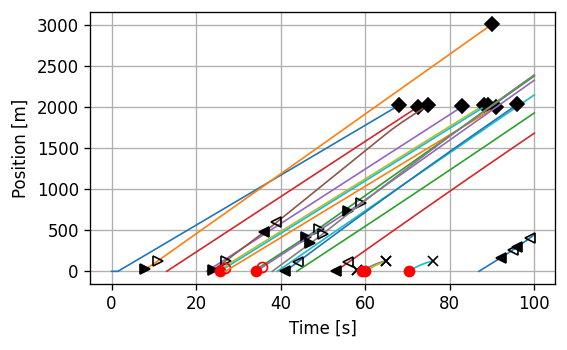

In [74]:
rec.plot('t', 'x')